## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.65
    pseudo_threshold = 0.90

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") > float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{n_epochs:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
        print(f"[Valid | {epoch + 1:03d}/{n_epochs:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        if epoch - best_epoch >= 50:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 1000

# Whether to do semi-supervised learning.
# do_semi = False
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/1000] loss = 5.39197, acc = 0.07496
[Valid | 001/1000][Best | 1] loss = 4.02796[4.02796], acc = 0.09871[0.09871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/1000] loss = 2.61735, acc = 0.08520
[Valid | 002/1000][Best | 1] loss = 2.43802[4.02796], acc = 0.08879[0.09871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/1000] loss = 2.46379, acc = 0.09347
[Valid | 003/1000][Best | 1] loss = 2.41961[4.02796], acc = 0.09028[0.09871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/1000] loss = 2.43948, acc = 0.08424
[Valid | 004/1000][Best | 1] loss = 2.41672[4.02796], acc = 0.08532[0.09871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/1000] loss = 2.42573, acc = 0.09226
[Valid | 005/1000][Best | 1] loss = 2.40753[4.02796], acc = 0.08631[0.09871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/1000] loss = 2.42383, acc = 0.10185
[Valid | 006/1000][Best | 6] loss = 2.40689[2.40689], acc = 0.09970[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/1000] loss = 2.41965, acc = 0.08490
[Valid | 007/1000][Best | 6] loss = 2.39315[2.40689], acc = 0.09772[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/1000] loss = 2.41924, acc = 0.09655
[Valid | 008/1000][Best | 6] loss = 2.41058[2.40689], acc = 0.07589[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/1000] loss = 2.41952, acc = 0.08772
[Valid | 009/1000][Best | 6] loss = 2.40070[2.40689], acc = 0.08631[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/1000] loss = 2.41330, acc = 0.08984
[Valid | 010/1000][Best | 6] loss = 2.40240[2.40689], acc = 0.09177[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/1000] loss = 2.41239, acc = 0.09529
[Valid | 011/1000][Best | 6] loss = 2.40566[2.40689], acc = 0.09474[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/1000] loss = 2.42108, acc = 0.08157
[Valid | 012/1000][Best | 6] loss = 2.40264[2.40689], acc = 0.09474[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/1000] loss = 2.41364, acc = 0.09589
[Valid | 013/1000][Best | 6] loss = 2.40640[2.40689], acc = 0.09077[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/1000] loss = 2.41395, acc = 0.09917
[Valid | 014/1000][Best | 6] loss = 2.40491[2.40689], acc = 0.09127[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/1000] loss = 2.41756, acc = 0.08888
[Valid | 015/1000][Best | 6] loss = 2.39299[2.40689], acc = 0.09276[0.09970]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/1000] loss = 2.41429, acc = 0.10119
[Valid | 016/1000][Best | 16] loss = 2.39625[2.39625], acc = 0.10268[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/1000] loss = 2.40974, acc = 0.09176
[Valid | 017/1000][Best | 16] loss = 2.39258[2.39625], acc = 0.09821[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/1000] loss = 2.40957, acc = 0.09625
[Valid | 018/1000][Best | 16] loss = 2.40341[2.39625], acc = 0.09226[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/1000] loss = 2.41176, acc = 0.09645
[Valid | 019/1000][Best | 16] loss = 2.39516[2.39625], acc = 0.08581[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/1000] loss = 2.41180, acc = 0.09473
[Valid | 020/1000][Best | 16] loss = 2.39419[2.39625], acc = 0.10069[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/1000] loss = 2.40781, acc = 0.09372
[Valid | 021/1000][Best | 16] loss = 2.40375[2.39625], acc = 0.09425[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/1000] loss = 2.41554, acc = 0.08823
[Valid | 022/1000][Best | 16] loss = 2.40462[2.39625], acc = 0.09425[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/1000] loss = 2.41335, acc = 0.08989
[Valid | 023/1000][Best | 16] loss = 2.39897[2.39625], acc = 0.10714[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/1000] loss = 2.41455, acc = 0.09408
[Valid | 024/1000][Best | 16] loss = 2.40744[2.39625], acc = 0.10218[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/1000] loss = 2.40753, acc = 0.10891
[Valid | 025/1000][Best | 16] loss = 2.39713[2.39625], acc = 0.11062[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/1000] loss = 2.40966, acc = 0.09539
[Valid | 026/1000][Best | 16] loss = 2.40401[2.39625], acc = 0.09077[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/1000] loss = 2.40759, acc = 0.09665
[Valid | 027/1000][Best | 16] loss = 2.39927[2.39625], acc = 0.09177[0.10268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/1000] loss = 2.41216, acc = 0.08096
[Valid | 028/1000][Best | 28] loss = 2.39448[2.39448], acc = 0.11161[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/1000] loss = 2.41318, acc = 0.08298
[Valid | 029/1000][Best | 28] loss = 2.39545[2.39448], acc = 0.11359[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/1000] loss = 2.41070, acc = 0.09130
[Valid | 030/1000][Best | 28] loss = 2.38609[2.39448], acc = 0.08829[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/1000] loss = 2.41013, acc = 0.09272
[Valid | 031/1000][Best | 28] loss = 2.40060[2.39448], acc = 0.09177[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/1000] loss = 2.41193, acc = 0.09287
[Valid | 032/1000][Best | 28] loss = 2.40157[2.39448], acc = 0.09772[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/1000] loss = 2.40645, acc = 0.08944
[Valid | 033/1000][Best | 28] loss = 2.39456[2.39448], acc = 0.10119[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/1000] loss = 2.40469, acc = 0.10654
[Valid | 034/1000][Best | 28] loss = 2.41906[2.39448], acc = 0.10665[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/1000] loss = 2.41033, acc = 0.09019
[Valid | 035/1000][Best | 28] loss = 2.39057[2.39448], acc = 0.09921[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/1000] loss = 2.40703, acc = 0.08212
[Valid | 036/1000][Best | 28] loss = 2.39806[2.39448], acc = 0.08829[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/1000] loss = 2.41212, acc = 0.08520
[Valid | 037/1000][Best | 28] loss = 2.40154[2.39448], acc = 0.08929[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/1000] loss = 2.40571, acc = 0.09544
[Valid | 038/1000][Best | 28] loss = 2.40223[2.39448], acc = 0.08284[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/1000] loss = 2.40629, acc = 0.09241
[Valid | 039/1000][Best | 28] loss = 2.39274[2.39448], acc = 0.10565[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/1000] loss = 2.41586, acc = 0.08248
[Valid | 040/1000][Best | 28] loss = 2.40061[2.39448], acc = 0.09375[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/1000] loss = 2.40873, acc = 0.08500
[Valid | 041/1000][Best | 28] loss = 2.40810[2.39448], acc = 0.08185[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/1000] loss = 2.40358, acc = 0.08737
[Valid | 042/1000][Best | 28] loss = 2.39491[2.39448], acc = 0.09623[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/1000] loss = 2.40652, acc = 0.09100
[Valid | 043/1000][Best | 28] loss = 2.40176[2.39448], acc = 0.10367[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/1000] loss = 2.40516, acc = 0.09372
[Valid | 044/1000][Best | 28] loss = 2.39010[2.39448], acc = 0.10268[0.11161]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/1000] loss = 2.40472, acc = 0.09741
[Valid | 045/1000][Best | 45] loss = 2.39192[2.39192], acc = 0.11210[0.11210]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/1000] loss = 2.39829, acc = 0.10518
[Valid | 046/1000][Best | 46] loss = 2.35924[2.35924], acc = 0.12550[0.12550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/1000] loss = 2.40202, acc = 0.10074
[Valid | 047/1000][Best | 46] loss = 2.39390[2.35924], acc = 0.11558[0.12550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/1000] loss = 2.39707, acc = 0.10654
[Valid | 048/1000][Best | 48] loss = 2.35025[2.35025], acc = 0.13591[0.13591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/1000] loss = 2.39074, acc = 0.11320
[Valid | 049/1000][Best | 48] loss = 2.37226[2.35025], acc = 0.12946[0.13591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/1000] loss = 2.39759, acc = 0.10205
[Valid | 050/1000][Best | 48] loss = 2.35258[2.35025], acc = 0.12450[0.13591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/1000] loss = 2.38584, acc = 0.11224
[Valid | 051/1000][Best | 51] loss = 2.33241[2.33241], acc = 0.15526[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/1000] loss = 2.39658, acc = 0.09907
[Valid | 052/1000][Best | 51] loss = 2.36018[2.33241], acc = 0.08978[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/1000] loss = 2.38107, acc = 0.09897
[Valid | 053/1000][Best | 51] loss = 2.34925[2.33241], acc = 0.12798[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/1000] loss = 2.38291, acc = 0.11138
[Valid | 054/1000][Best | 51] loss = 2.35124[2.33241], acc = 0.13095[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/1000] loss = 2.39207, acc = 0.10386
[Valid | 055/1000][Best | 51] loss = 2.39082[2.33241], acc = 0.08036[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/1000] loss = 2.38986, acc = 0.10679
[Valid | 056/1000][Best | 51] loss = 2.34365[2.33241], acc = 0.13492[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/1000] loss = 2.38869, acc = 0.10674
[Valid | 057/1000][Best | 51] loss = 2.36279[2.33241], acc = 0.11359[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/1000] loss = 2.38526, acc = 0.10467
[Valid | 058/1000][Best | 51] loss = 2.38916[2.33241], acc = 0.12450[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/1000] loss = 2.38939, acc = 0.10215
[Valid | 059/1000][Best | 51] loss = 2.35176[2.33241], acc = 0.14435[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/1000] loss = 2.38140, acc = 0.10745
[Valid | 060/1000][Best | 51] loss = 2.35989[2.33241], acc = 0.13194[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/1000] loss = 2.37809, acc = 0.10644
[Valid | 061/1000][Best | 51] loss = 2.32996[2.33241], acc = 0.12351[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/1000] loss = 2.37010, acc = 0.11183
[Valid | 062/1000][Best | 51] loss = 2.33920[2.33241], acc = 0.12401[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/1000] loss = 2.37432, acc = 0.11597
[Valid | 063/1000][Best | 51] loss = 2.32732[2.33241], acc = 0.12500[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/1000] loss = 2.36500, acc = 0.11194
[Valid | 064/1000][Best | 51] loss = 2.36103[2.33241], acc = 0.10714[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/1000] loss = 2.37200, acc = 0.11728
[Valid | 065/1000][Best | 51] loss = 2.31348[2.33241], acc = 0.15278[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/1000] loss = 2.36606, acc = 0.11683
[Valid | 066/1000][Best | 51] loss = 2.34365[2.33241], acc = 0.14732[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/1000] loss = 2.36505, acc = 0.10583
[Valid | 067/1000][Best | 51] loss = 2.32739[2.33241], acc = 0.12153[0.15526]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/1000] loss = 2.36821, acc = 0.10936
[Valid | 068/1000][Best | 68] loss = 2.29634[2.29634], acc = 0.16022[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/1000] loss = 2.35558, acc = 0.12328
[Valid | 069/1000][Best | 68] loss = 2.30436[2.29634], acc = 0.14782[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/1000] loss = 2.35902, acc = 0.12561
[Valid | 070/1000][Best | 68] loss = 2.32366[2.29634], acc = 0.14583[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/1000] loss = 2.36212, acc = 0.12223
[Valid | 071/1000][Best | 68] loss = 2.29800[2.29634], acc = 0.16121[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/1000] loss = 2.35995, acc = 0.12278
[Valid | 072/1000][Best | 68] loss = 2.29039[2.29634], acc = 0.15873[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/1000] loss = 2.35754, acc = 0.12334
[Valid | 073/1000][Best | 68] loss = 2.29508[2.29634], acc = 0.14782[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/1000] loss = 2.35671, acc = 0.12349
[Valid | 074/1000][Best | 68] loss = 2.34212[2.29634], acc = 0.12748[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/1000] loss = 2.35855, acc = 0.12530
[Valid | 075/1000][Best | 68] loss = 2.27910[2.29634], acc = 0.13343[0.16022]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/1000] loss = 2.33893, acc = 0.12661
[Valid | 076/1000][Best | 76] loss = 2.29163[2.29163], acc = 0.16220[0.16220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/1000] loss = 2.35217, acc = 0.11935
[Valid | 077/1000][Best | 76] loss = 2.32590[2.29163], acc = 0.13194[0.16220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/1000] loss = 2.34922, acc = 0.13398
[Valid | 078/1000][Best | 76] loss = 2.29892[2.29163], acc = 0.15575[0.16220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/1000] loss = 2.35299, acc = 0.12742
[Valid | 079/1000][Best | 79] loss = 2.26400[2.26400], acc = 0.17758[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/1000] loss = 2.34476, acc = 0.12666
[Valid | 080/1000][Best | 79] loss = 2.27028[2.26400], acc = 0.18155[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/1000] loss = 2.35304, acc = 0.12439
[Valid | 081/1000][Best | 79] loss = 2.31495[2.26400], acc = 0.15774[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/1000] loss = 2.34124, acc = 0.13292
[Valid | 082/1000][Best | 79] loss = 2.28112[2.26400], acc = 0.15278[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/1000] loss = 2.34961, acc = 0.12480
[Valid | 083/1000][Best | 79] loss = 2.33343[2.26400], acc = 0.13938[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/1000] loss = 2.33842, acc = 0.13403
[Valid | 084/1000][Best | 79] loss = 2.29625[2.26400], acc = 0.15129[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/1000] loss = 2.33660, acc = 0.14563
[Valid | 085/1000][Best | 79] loss = 2.31128[2.26400], acc = 0.14782[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/1000] loss = 2.34309, acc = 0.13786
[Valid | 086/1000][Best | 79] loss = 2.31321[2.26400], acc = 0.14435[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/1000] loss = 2.33981, acc = 0.14003
[Valid | 087/1000][Best | 79] loss = 2.41226[2.26400], acc = 0.11111[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/1000] loss = 2.34161, acc = 0.13025
[Valid | 088/1000][Best | 79] loss = 2.31410[2.26400], acc = 0.13641[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/1000] loss = 2.33377, acc = 0.14316
[Valid | 089/1000][Best | 79] loss = 2.25680[2.26400], acc = 0.16865[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/1000] loss = 2.33531, acc = 0.13837
[Valid | 090/1000][Best | 79] loss = 2.25781[2.26400], acc = 0.17163[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/1000] loss = 2.32676, acc = 0.14069
[Valid | 091/1000][Best | 79] loss = 2.25290[2.26400], acc = 0.15923[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/1000] loss = 2.33323, acc = 0.14023
[Valid | 092/1000][Best | 79] loss = 2.26114[2.26400], acc = 0.15278[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/1000] loss = 2.31594, acc = 0.13701
[Valid | 093/1000][Best | 79] loss = 2.27963[2.26400], acc = 0.16121[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/1000] loss = 2.32151, acc = 0.13630
[Valid | 094/1000][Best | 79] loss = 2.23125[2.26400], acc = 0.17510[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/1000] loss = 2.33556, acc = 0.13408
[Valid | 095/1000][Best | 79] loss = 2.27312[2.26400], acc = 0.15377[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/1000] loss = 2.32029, acc = 0.14049
[Valid | 096/1000][Best | 79] loss = 2.28032[2.26400], acc = 0.15079[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/1000] loss = 2.32396, acc = 0.13514
[Valid | 097/1000][Best | 79] loss = 2.28301[2.26400], acc = 0.15427[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/1000] loss = 2.32422, acc = 0.14765
[Valid | 098/1000][Best | 79] loss = 2.33200[2.26400], acc = 0.12401[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/1000] loss = 2.32256, acc = 0.15063
[Valid | 099/1000][Best | 79] loss = 2.37082[2.26400], acc = 0.13244[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/1000] loss = 2.30365, acc = 0.15759
[Valid | 100/1000][Best | 79] loss = 2.27581[2.26400], acc = 0.15327[0.17758]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/1000] loss = 2.32276, acc = 0.15002
[Valid | 101/1000][Best | 101] loss = 2.24836[2.24836], acc = 0.19742[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/1000] loss = 2.32262, acc = 0.14346
[Valid | 102/1000][Best | 101] loss = 2.23911[2.24836], acc = 0.15724[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/1000] loss = 2.30353, acc = 0.16278
[Valid | 103/1000][Best | 103] loss = 2.18077[2.18077], acc = 0.21726[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/1000] loss = 2.32146, acc = 0.15668
[Valid | 104/1000][Best | 103] loss = 2.22457[2.18077], acc = 0.18452[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/1000] loss = 2.32528, acc = 0.13736
[Valid | 105/1000][Best | 103] loss = 2.26893[2.18077], acc = 0.17312[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/1000] loss = 2.30495, acc = 0.14165
[Valid | 106/1000][Best | 103] loss = 2.20389[2.18077], acc = 0.18750[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/1000] loss = 2.30777, acc = 0.14982
[Valid | 107/1000][Best | 103] loss = 2.21475[2.18077], acc = 0.18849[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/1000] loss = 2.30120, acc = 0.14220
[Valid | 108/1000][Best | 103] loss = 2.21533[2.18077], acc = 0.18353[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/1000] loss = 2.29991, acc = 0.15279
[Valid | 109/1000][Best | 103] loss = 2.28338[2.18077], acc = 0.17411[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/1000] loss = 2.30075, acc = 0.15738
[Valid | 110/1000][Best | 103] loss = 2.26554[2.18077], acc = 0.17956[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/1000] loss = 2.30379, acc = 0.15456
[Valid | 111/1000][Best | 103] loss = 2.34841[2.18077], acc = 0.13591[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/1000] loss = 2.29473, acc = 0.16167
[Valid | 112/1000][Best | 103] loss = 2.20661[2.18077], acc = 0.21478[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/1000] loss = 2.29966, acc = 0.16430
[Valid | 113/1000][Best | 103] loss = 2.21001[2.18077], acc = 0.19792[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/1000] loss = 2.29665, acc = 0.15834
[Valid | 114/1000][Best | 103] loss = 2.20901[2.18077], acc = 0.18700[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/1000] loss = 2.31434, acc = 0.15214
[Valid | 115/1000][Best | 103] loss = 2.21232[2.18077], acc = 0.19296[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/1000] loss = 2.28781, acc = 0.16167
[Valid | 116/1000][Best | 103] loss = 2.19436[2.18077], acc = 0.19643[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/1000] loss = 2.29184, acc = 0.15300
[Valid | 117/1000][Best | 103] loss = 2.24536[2.18077], acc = 0.16220[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/1000] loss = 2.29443, acc = 0.16520
[Valid | 118/1000][Best | 103] loss = 2.33803[2.18077], acc = 0.13740[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/1000] loss = 2.29259, acc = 0.15723
[Valid | 119/1000][Best | 103] loss = 2.19379[2.18077], acc = 0.19048[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/1000] loss = 2.28093, acc = 0.16566
[Valid | 120/1000][Best | 103] loss = 2.29251[2.18077], acc = 0.13938[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/1000] loss = 2.29054, acc = 0.16677
[Valid | 121/1000][Best | 103] loss = 2.30067[2.18077], acc = 0.13839[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/1000] loss = 2.28502, acc = 0.16258
[Valid | 122/1000][Best | 103] loss = 2.27876[2.18077], acc = 0.17907[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/1000] loss = 2.29293, acc = 0.16021
[Valid | 123/1000][Best | 103] loss = 2.22877[2.18077], acc = 0.16865[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/1000] loss = 2.28229, acc = 0.15643
[Valid | 124/1000][Best | 103] loss = 2.26755[2.18077], acc = 0.15675[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/1000] loss = 2.27268, acc = 0.17691
[Valid | 125/1000][Best | 103] loss = 2.19054[2.18077], acc = 0.21379[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/1000] loss = 2.29063, acc = 0.16132
[Valid | 126/1000][Best | 103] loss = 2.21342[2.18077], acc = 0.19494[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/1000] loss = 2.28158, acc = 0.17297
[Valid | 127/1000][Best | 103] loss = 2.19275[2.18077], acc = 0.20486[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/1000] loss = 2.27674, acc = 0.17474
[Valid | 128/1000][Best | 103] loss = 2.20531[2.18077], acc = 0.17411[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/1000] loss = 2.28031, acc = 0.17080
[Valid | 129/1000][Best | 103] loss = 2.21376[2.18077], acc = 0.17708[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/1000] loss = 2.27078, acc = 0.17665
[Valid | 130/1000][Best | 103] loss = 2.22834[2.18077], acc = 0.17808[0.21726]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/1000] loss = 2.28309, acc = 0.17797
[Valid | 131/1000][Best | 131] loss = 2.17896[2.17896], acc = 0.23016[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/1000] loss = 2.27285, acc = 0.17519
[Valid | 132/1000][Best | 131] loss = 2.17048[2.17896], acc = 0.19296[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/1000] loss = 2.28773, acc = 0.16208
[Valid | 133/1000][Best | 131] loss = 2.22551[2.17896], acc = 0.20833[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/1000] loss = 2.27121, acc = 0.17317
[Valid | 134/1000][Best | 131] loss = 2.17959[2.17896], acc = 0.21627[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/1000] loss = 2.26247, acc = 0.17383
[Valid | 135/1000][Best | 131] loss = 2.21035[2.17896], acc = 0.20536[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/1000] loss = 2.25655, acc = 0.18745
[Valid | 136/1000][Best | 131] loss = 2.18790[2.17896], acc = 0.21032[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/1000] loss = 2.25087, acc = 0.18594
[Valid | 137/1000][Best | 131] loss = 2.16096[2.17896], acc = 0.20784[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/1000] loss = 2.26605, acc = 0.18563
[Valid | 138/1000][Best | 131] loss = 2.20416[2.17896], acc = 0.19742[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/1000] loss = 2.24718, acc = 0.19128
[Valid | 139/1000][Best | 131] loss = 2.19816[2.17896], acc = 0.21478[0.23016]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/1000] loss = 2.24461, acc = 0.19118
[Valid | 140/1000][Best | 140] loss = 2.17263[2.17263], acc = 0.24653[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/1000] loss = 2.25296, acc = 0.19194
[Valid | 141/1000][Best | 140] loss = 2.18145[2.17263], acc = 0.20883[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/1000] loss = 2.23075, acc = 0.19744
[Valid | 142/1000][Best | 140] loss = 2.17445[2.17263], acc = 0.22421[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/1000] loss = 2.24091, acc = 0.18684
[Valid | 143/1000][Best | 140] loss = 2.19681[2.17263], acc = 0.20635[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/1000] loss = 2.23528, acc = 0.18947
[Valid | 144/1000][Best | 140] loss = 2.14300[2.17263], acc = 0.24454[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/1000] loss = 2.23282, acc = 0.18745
[Valid | 145/1000][Best | 140] loss = 2.23127[2.17263], acc = 0.20883[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/1000] loss = 2.24482, acc = 0.19164
[Valid | 146/1000][Best | 140] loss = 2.12243[2.17263], acc = 0.23760[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/1000] loss = 2.20769, acc = 0.20410
[Valid | 147/1000][Best | 140] loss = 2.12113[2.17263], acc = 0.24504[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/1000] loss = 2.20710, acc = 0.20354
[Valid | 148/1000][Best | 140] loss = 2.15969[2.17263], acc = 0.20536[0.24653]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/1000] loss = 2.22115, acc = 0.20233
[Valid | 149/1000][Best | 149] loss = 2.11797[2.11797], acc = 0.24950[0.24950]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/1000] loss = 2.20645, acc = 0.20667
[Valid | 150/1000][Best | 149] loss = 2.15145[2.11797], acc = 0.21776[0.24950]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/1000] loss = 2.20848, acc = 0.20763
[Valid | 151/1000][Best | 149] loss = 2.08924[2.11797], acc = 0.24802[0.24950]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/1000] loss = 2.21280, acc = 0.20379
[Valid | 152/1000][Best | 152] loss = 2.09291[2.09291], acc = 0.26538[0.26538]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/1000] loss = 2.19024, acc = 0.21191
[Valid | 153/1000][Best | 152] loss = 2.10068[2.09291], acc = 0.25843[0.26538]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/1000] loss = 2.21414, acc = 0.21948
[Valid | 154/1000][Best | 152] loss = 2.14882[2.09291], acc = 0.22619[0.26538]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/1000] loss = 2.22337, acc = 0.19239
[Valid | 155/1000][Best | 152] loss = 2.11797[2.09291], acc = 0.23264[0.26538]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/1000] loss = 2.17998, acc = 0.22780
[Valid | 156/1000][Best | 156] loss = 2.06516[2.06516], acc = 0.27034[0.27034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/1000] loss = 2.18895, acc = 0.22205
[Valid | 157/1000][Best | 156] loss = 2.09330[2.06516], acc = 0.24405[0.27034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/1000] loss = 2.19429, acc = 0.21585
[Valid | 158/1000][Best | 156] loss = 2.07782[2.06516], acc = 0.25446[0.27034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/1000] loss = 2.18452, acc = 0.21434
[Valid | 159/1000][Best | 156] loss = 2.10607[2.06516], acc = 0.24702[0.27034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/1000] loss = 2.16744, acc = 0.22382
[Valid | 160/1000][Best | 156] loss = 2.08305[2.06516], acc = 0.26488[0.27034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/1000] loss = 2.15555, acc = 0.23098
[Valid | 161/1000][Best | 161] loss = 2.06498[2.06498], acc = 0.27331[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/1000] loss = 2.16436, acc = 0.22251
[Valid | 162/1000][Best | 161] loss = 2.09000[2.06498], acc = 0.26290[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/1000] loss = 2.17224, acc = 0.22977
[Valid | 163/1000][Best | 161] loss = 2.05108[2.06498], acc = 0.25744[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/1000] loss = 2.18447, acc = 0.21943
[Valid | 164/1000][Best | 161] loss = 2.16480[2.06498], acc = 0.21677[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/1000] loss = 2.15969, acc = 0.22816
[Valid | 165/1000][Best | 161] loss = 2.08031[2.06498], acc = 0.25248[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/1000] loss = 2.16058, acc = 0.23159
[Valid | 166/1000][Best | 161] loss = 2.04080[2.06498], acc = 0.27331[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/1000] loss = 2.17633, acc = 0.21585
[Valid | 167/1000][Best | 161] loss = 2.05584[2.06498], acc = 0.27133[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/1000] loss = 2.13475, acc = 0.22886
[Valid | 168/1000][Best | 161] loss = 2.06221[2.06498], acc = 0.26438[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/1000] loss = 2.15169, acc = 0.22518
[Valid | 169/1000][Best | 161] loss = 2.01683[2.06498], acc = 0.26438[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/1000] loss = 2.15694, acc = 0.24026
[Valid | 170/1000][Best | 161] loss = 2.03174[2.06498], acc = 0.26438[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/1000] loss = 2.15567, acc = 0.23507
[Valid | 171/1000][Best | 161] loss = 2.03408[2.06498], acc = 0.26438[0.27331]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/1000] loss = 2.10791, acc = 0.24939
[Valid | 172/1000][Best | 172] loss = 1.98243[1.98243], acc = 0.29018[0.29018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/1000] loss = 2.12902, acc = 0.25651
[Valid | 173/1000][Best | 172] loss = 2.04742[1.98243], acc = 0.25298[0.29018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/1000] loss = 2.13132, acc = 0.23774
[Valid | 174/1000][Best | 172] loss = 1.99977[1.98243], acc = 0.27530[0.29018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/1000] loss = 2.14440, acc = 0.24269
[Valid | 175/1000][Best | 172] loss = 2.01012[1.98243], acc = 0.28373[0.29018]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/1000] loss = 2.12675, acc = 0.25066
[Valid | 176/1000][Best | 176] loss = 1.96306[1.96306], acc = 0.31796[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/1000] loss = 2.12417, acc = 0.23885
[Valid | 177/1000][Best | 176] loss = 1.97447[1.96306], acc = 0.29315[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/1000] loss = 2.11766, acc = 0.24445
[Valid | 178/1000][Best | 176] loss = 1.98765[1.96306], acc = 0.28819[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/1000] loss = 2.12187, acc = 0.25348
[Valid | 179/1000][Best | 176] loss = 1.99169[1.96306], acc = 0.28075[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/1000] loss = 2.11899, acc = 0.24233
[Valid | 180/1000][Best | 176] loss = 2.03633[1.96306], acc = 0.26687[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/1000] loss = 2.11081, acc = 0.24491
[Valid | 181/1000][Best | 176] loss = 1.94930[1.96306], acc = 0.30704[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/1000] loss = 2.11174, acc = 0.24647
[Valid | 182/1000][Best | 176] loss = 1.95882[1.96306], acc = 0.30903[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/1000] loss = 2.09633, acc = 0.25691
[Valid | 183/1000][Best | 176] loss = 1.99650[1.96306], acc = 0.29514[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/1000] loss = 2.11317, acc = 0.23976
[Valid | 184/1000][Best | 176] loss = 1.96776[1.96306], acc = 0.29960[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/1000] loss = 2.10691, acc = 0.25272
[Valid | 185/1000][Best | 176] loss = 1.98823[1.96306], acc = 0.29117[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/1000] loss = 2.08731, acc = 0.25974
[Valid | 186/1000][Best | 176] loss = 1.97635[1.96306], acc = 0.28472[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/1000] loss = 2.07797, acc = 0.25757
[Valid | 187/1000][Best | 176] loss = 1.96992[1.96306], acc = 0.31300[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/1000] loss = 2.08650, acc = 0.26322
[Valid | 188/1000][Best | 176] loss = 2.01530[1.96306], acc = 0.25694[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/1000] loss = 2.06970, acc = 0.26892
[Valid | 189/1000][Best | 176] loss = 2.01912[1.96306], acc = 0.27679[0.31796]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/1000] loss = 2.08881, acc = 0.25641
[Valid | 190/1000][Best | 190] loss = 1.91675[1.91675], acc = 0.33631[0.33631]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/1000] loss = 2.07815, acc = 0.26236
[Valid | 191/1000][Best | 190] loss = 1.90264[1.91675], acc = 0.33631[0.33631]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/1000] loss = 2.07669, acc = 0.26629
[Valid | 192/1000][Best | 190] loss = 1.94552[1.91675], acc = 0.31746[0.33631]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/1000] loss = 2.06431, acc = 0.26801
[Valid | 193/1000][Best | 190] loss = 1.96492[1.91675], acc = 0.31200[0.33631]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/1000] loss = 2.06001, acc = 0.26982
[Valid | 194/1000][Best | 190] loss = 1.92619[1.91675], acc = 0.31448[0.33631]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/1000] loss = 2.08715, acc = 0.26680
[Valid | 195/1000][Best | 195] loss = 1.89334[1.89334], acc = 0.33879[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/1000] loss = 2.05936, acc = 0.27331
[Valid | 196/1000][Best | 195] loss = 1.90176[1.89334], acc = 0.32292[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/1000] loss = 2.05729, acc = 0.27805
[Valid | 197/1000][Best | 195] loss = 1.88244[1.89334], acc = 0.33879[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/1000] loss = 2.09395, acc = 0.25590
[Valid | 198/1000][Best | 195] loss = 1.93919[1.89334], acc = 0.32192[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/1000] loss = 2.06228, acc = 0.27204
[Valid | 199/1000][Best | 195] loss = 1.90151[1.89334], acc = 0.32837[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/1000] loss = 2.06002, acc = 0.26387
[Valid | 200/1000][Best | 195] loss = 1.92310[1.89334], acc = 0.32788[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/1000] loss = 2.06190, acc = 0.27083
[Valid | 201/1000][Best | 195] loss = 1.88598[1.89334], acc = 0.33085[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/1000] loss = 2.08127, acc = 0.26836
[Valid | 202/1000][Best | 195] loss = 1.92010[1.89334], acc = 0.31052[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/1000] loss = 2.04995, acc = 0.27235
[Valid | 203/1000][Best | 195] loss = 1.92157[1.89334], acc = 0.32044[0.33879]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/1000] loss = 2.04158, acc = 0.28213
[Valid | 204/1000][Best | 204] loss = 1.89328[1.89328], acc = 0.34177[0.34177]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/1000] loss = 2.02782, acc = 0.28208
[Valid | 205/1000][Best | 204] loss = 1.95456[1.89328], acc = 0.32688[0.34177]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/1000] loss = 2.04175, acc = 0.27406
[Valid | 206/1000][Best | 204] loss = 1.89980[1.89328], acc = 0.32391[0.34177]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/1000] loss = 2.03348, acc = 0.26347
[Valid | 207/1000][Best | 204] loss = 1.92255[1.89328], acc = 0.33135[0.34177]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/1000] loss = 2.01070, acc = 0.27320
[Valid | 208/1000][Best | 208] loss = 1.84480[1.84480], acc = 0.34871[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/1000] loss = 2.04208, acc = 0.28304
[Valid | 209/1000][Best | 208] loss = 1.88952[1.84480], acc = 0.34226[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/1000] loss = 2.00429, acc = 0.28819
[Valid | 210/1000][Best | 208] loss = 1.91130[1.84480], acc = 0.32540[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/1000] loss = 2.02622, acc = 0.28329
[Valid | 211/1000][Best | 208] loss = 1.89119[1.84480], acc = 0.29464[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/1000] loss = 2.04357, acc = 0.26866
[Valid | 212/1000][Best | 208] loss = 1.87677[1.84480], acc = 0.33730[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/1000] loss = 2.01969, acc = 0.29146
[Valid | 213/1000][Best | 208] loss = 1.92260[1.84480], acc = 0.30804[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/1000] loss = 2.02078, acc = 0.28309
[Valid | 214/1000][Best | 208] loss = 1.90274[1.84480], acc = 0.36657[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/1000] loss = 2.00140, acc = 0.29207
[Valid | 215/1000][Best | 208] loss = 1.85787[1.84480], acc = 0.34970[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/1000] loss = 2.02724, acc = 0.28541
[Valid | 216/1000][Best | 208] loss = 1.85002[1.84480], acc = 0.36458[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/1000] loss = 2.00455, acc = 0.27774
[Valid | 217/1000][Best | 208] loss = 1.83670[1.84480], acc = 0.34772[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/1000] loss = 2.01579, acc = 0.27810
[Valid | 218/1000][Best | 208] loss = 1.84509[1.84480], acc = 0.34177[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/1000] loss = 2.00841, acc = 0.29126
[Valid | 219/1000][Best | 208] loss = 1.86081[1.84480], acc = 0.34573[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/1000] loss = 2.01186, acc = 0.29691
[Valid | 220/1000][Best | 208] loss = 1.86176[1.84480], acc = 0.34772[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/1000] loss = 1.99415, acc = 0.29646
[Valid | 221/1000][Best | 208] loss = 1.90739[1.84480], acc = 0.34226[0.34871]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/1000] loss = 2.00154, acc = 0.30478
[Valid | 222/1000][Best | 222] loss = 1.80950[1.80950], acc = 0.37153[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/1000] loss = 1.98718, acc = 0.28561
[Valid | 223/1000][Best | 222] loss = 1.92146[1.80950], acc = 0.32093[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/1000] loss = 2.01874, acc = 0.28143
[Valid | 224/1000][Best | 222] loss = 1.85218[1.80950], acc = 0.36954[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/1000] loss = 1.97442, acc = 0.29656
[Valid | 225/1000][Best | 222] loss = 1.84758[1.80950], acc = 0.35863[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/1000] loss = 1.97715, acc = 0.29696
[Valid | 226/1000][Best | 222] loss = 1.90827[1.80950], acc = 0.33234[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/1000] loss = 1.95754, acc = 0.30216
[Valid | 227/1000][Best | 222] loss = 1.88195[1.80950], acc = 0.32688[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/1000] loss = 1.97046, acc = 0.30493
[Valid | 228/1000][Best | 222] loss = 1.83495[1.80950], acc = 0.34524[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/1000] loss = 1.98366, acc = 0.30771
[Valid | 229/1000][Best | 222] loss = 1.78414[1.80950], acc = 0.36855[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/1000] loss = 1.96403, acc = 0.31643
[Valid | 230/1000][Best | 222] loss = 1.81494[1.80950], acc = 0.35516[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/1000] loss = 1.98431, acc = 0.28743
[Valid | 231/1000][Best | 222] loss = 1.81810[1.80950], acc = 0.36260[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/1000] loss = 1.97370, acc = 0.30397
[Valid | 232/1000][Best | 222] loss = 1.89359[1.80950], acc = 0.32540[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/1000] loss = 1.98079, acc = 0.29863
[Valid | 233/1000][Best | 222] loss = 1.87128[1.80950], acc = 0.33829[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/1000] loss = 1.97230, acc = 0.30367
[Valid | 234/1000][Best | 222] loss = 1.81315[1.80950], acc = 0.36359[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/1000] loss = 1.96958, acc = 0.30206
[Valid | 235/1000][Best | 222] loss = 1.88323[1.80950], acc = 0.32639[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/1000] loss = 1.94001, acc = 0.31517
[Valid | 236/1000][Best | 222] loss = 1.86397[1.80950], acc = 0.33085[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/1000] loss = 1.96821, acc = 0.31053
[Valid | 237/1000][Best | 222] loss = 1.83412[1.80950], acc = 0.36260[0.37153]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/1000] loss = 1.96672, acc = 0.31245
[Valid | 238/1000][Best | 238] loss = 1.76414[1.76414], acc = 0.37550[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/1000] loss = 1.96418, acc = 0.31467
[Valid | 239/1000][Best | 238] loss = 1.82065[1.76414], acc = 0.36161[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/1000] loss = 1.93779, acc = 0.32264
[Valid | 240/1000][Best | 238] loss = 1.81770[1.76414], acc = 0.35367[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/1000] loss = 1.95874, acc = 0.31169
[Valid | 241/1000][Best | 238] loss = 1.81467[1.76414], acc = 0.38641[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/1000] loss = 1.92591, acc = 0.32768
[Valid | 242/1000][Best | 238] loss = 1.87064[1.76414], acc = 0.33036[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/1000] loss = 1.96503, acc = 0.30927
[Valid | 243/1000][Best | 238] loss = 1.84677[1.76414], acc = 0.35317[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/1000] loss = 1.96793, acc = 0.30024
[Valid | 244/1000][Best | 238] loss = 1.78448[1.76414], acc = 0.38393[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/1000] loss = 1.94047, acc = 0.31295
[Valid | 245/1000][Best | 238] loss = 1.83223[1.76414], acc = 0.37401[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/1000] loss = 1.93872, acc = 0.32511
[Valid | 246/1000][Best | 238] loss = 1.77990[1.76414], acc = 0.37550[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/1000] loss = 1.94407, acc = 0.32531
[Valid | 247/1000][Best | 238] loss = 1.93892[1.76414], acc = 0.32887[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/1000] loss = 1.94105, acc = 0.31618
[Valid | 248/1000][Best | 238] loss = 1.79767[1.76414], acc = 0.37202[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/1000] loss = 1.92169, acc = 0.31971
[Valid | 249/1000][Best | 238] loss = 1.81170[1.76414], acc = 0.36062[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/1000] loss = 1.91163, acc = 0.32748
[Valid | 250/1000][Best | 238] loss = 1.76466[1.76414], acc = 0.38294[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/1000] loss = 1.94697, acc = 0.32652
[Valid | 251/1000][Best | 238] loss = 1.78003[1.76414], acc = 0.36111[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/1000] loss = 1.93319, acc = 0.32047
[Valid | 252/1000][Best | 238] loss = 1.82419[1.76414], acc = 0.36161[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/1000] loss = 1.90177, acc = 0.33243
[Valid | 253/1000][Best | 238] loss = 1.87478[1.76414], acc = 0.35466[0.37550]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/1000] loss = 1.94362, acc = 0.32213
[Valid | 254/1000][Best | 254] loss = 1.76319[1.76319], acc = 0.40972[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/1000] loss = 1.91946, acc = 0.33343
[Valid | 255/1000][Best | 254] loss = 1.74068[1.76319], acc = 0.38145[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/1000] loss = 1.91462, acc = 0.32435
[Valid | 256/1000][Best | 254] loss = 1.78353[1.76319], acc = 0.37302[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/1000] loss = 1.92103, acc = 0.32657
[Valid | 257/1000][Best | 254] loss = 1.78233[1.76319], acc = 0.39038[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/1000] loss = 1.91672, acc = 0.33717
[Valid | 258/1000][Best | 254] loss = 1.73234[1.76319], acc = 0.38690[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/1000] loss = 1.89361, acc = 0.31714
[Valid | 259/1000][Best | 254] loss = 1.77734[1.76319], acc = 0.36706[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/1000] loss = 1.93938, acc = 0.31628
[Valid | 260/1000][Best | 254] loss = 1.75011[1.76319], acc = 0.39385[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/1000] loss = 1.91019, acc = 0.32814
[Valid | 261/1000][Best | 254] loss = 1.74515[1.76319], acc = 0.37450[0.40972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/1000] loss = 1.90397, acc = 0.32980
[Valid | 262/1000][Best | 262] loss = 1.72077[1.72077], acc = 0.41220[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/1000] loss = 1.87467, acc = 0.34413
[Valid | 263/1000][Best | 262] loss = 1.75556[1.72077], acc = 0.39137[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/1000] loss = 1.86383, acc = 0.36557
[Valid | 264/1000][Best | 262] loss = 1.74352[1.72077], acc = 0.38492[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/1000] loss = 1.91589, acc = 0.33480
[Valid | 265/1000][Best | 262] loss = 1.76050[1.72077], acc = 0.38542[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/1000] loss = 1.89533, acc = 0.34332
[Valid | 266/1000][Best | 262] loss = 1.78528[1.72077], acc = 0.37698[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/1000] loss = 1.88796, acc = 0.33333
[Valid | 267/1000][Best | 262] loss = 1.77555[1.72077], acc = 0.38393[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/1000] loss = 1.88297, acc = 0.34211
[Valid | 268/1000][Best | 262] loss = 1.79344[1.72077], acc = 0.38095[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/1000] loss = 1.89712, acc = 0.33540
[Valid | 269/1000][Best | 262] loss = 1.84444[1.72077], acc = 0.36111[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/1000] loss = 1.87461, acc = 0.34731
[Valid | 270/1000][Best | 262] loss = 1.74601[1.72077], acc = 0.38889[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/1000] loss = 1.88021, acc = 0.33712
[Valid | 271/1000][Best | 262] loss = 1.74480[1.72077], acc = 0.39583[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/1000] loss = 1.88239, acc = 0.33797
[Valid | 272/1000][Best | 262] loss = 1.76239[1.72077], acc = 0.37698[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/1000] loss = 1.88557, acc = 0.34473
[Valid | 273/1000][Best | 262] loss = 1.71407[1.72077], acc = 0.40873[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/1000] loss = 1.85220, acc = 0.36178
[Valid | 274/1000][Best | 262] loss = 1.70226[1.72077], acc = 0.40724[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/1000] loss = 1.82827, acc = 0.35215
[Valid | 275/1000][Best | 262] loss = 1.75142[1.72077], acc = 0.39385[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/1000] loss = 1.87421, acc = 0.35997
[Valid | 276/1000][Best | 262] loss = 1.75825[1.72077], acc = 0.38641[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/1000] loss = 1.88030, acc = 0.34236
[Valid | 277/1000][Best | 262] loss = 1.72500[1.72077], acc = 0.39831[0.41220]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/1000] loss = 1.84196, acc = 0.36587
[Valid | 278/1000][Best | 278] loss = 1.68164[1.68164], acc = 0.43304[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/1000] loss = 1.87446, acc = 0.34857
[Valid | 279/1000][Best | 278] loss = 1.82904[1.68164], acc = 0.36657[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/1000] loss = 1.82568, acc = 0.36405
[Valid | 280/1000][Best | 278] loss = 1.75378[1.68164], acc = 0.40228[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/1000] loss = 1.83273, acc = 0.36410
[Valid | 281/1000][Best | 278] loss = 1.74138[1.68164], acc = 0.38492[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/1000] loss = 1.87087, acc = 0.36804
[Valid | 282/1000][Best | 278] loss = 1.73229[1.68164], acc = 0.41270[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/1000] loss = 1.85192, acc = 0.36531
[Valid | 283/1000][Best | 278] loss = 1.69580[1.68164], acc = 0.41071[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/1000] loss = 1.81787, acc = 0.37031
[Valid | 284/1000][Best | 278] loss = 1.73295[1.68164], acc = 0.42708[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/1000] loss = 1.85483, acc = 0.36415
[Valid | 285/1000][Best | 278] loss = 1.73106[1.68164], acc = 0.39484[0.43304]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/1000] loss = 1.82514, acc = 0.37843
[Valid | 286/1000][Best | 286] loss = 1.61914[1.61914], acc = 0.44792[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/1000] loss = 1.80399, acc = 0.38786
[Valid | 287/1000][Best | 286] loss = 1.72352[1.61914], acc = 0.39286[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/1000] loss = 1.82875, acc = 0.36360
[Valid | 288/1000][Best | 286] loss = 1.65585[1.61914], acc = 0.45288[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/1000] loss = 1.81423, acc = 0.37611
[Valid | 289/1000][Best | 286] loss = 1.73423[1.61914], acc = 0.40823[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/1000] loss = 1.84638, acc = 0.37757
[Valid | 290/1000][Best | 286] loss = 1.74049[1.61914], acc = 0.41319[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/1000] loss = 1.81093, acc = 0.37576
[Valid | 291/1000][Best | 286] loss = 1.76736[1.61914], acc = 0.39633[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/1000] loss = 1.81796, acc = 0.37621
[Valid | 292/1000][Best | 286] loss = 1.74272[1.61914], acc = 0.41220[0.44792]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/1000] loss = 1.82316, acc = 0.37036
[Valid | 293/1000][Best | 293] loss = 1.61075[1.61075], acc = 0.45933[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/1000] loss = 1.80912, acc = 0.37051
[Valid | 294/1000][Best | 293] loss = 1.68445[1.61075], acc = 0.44196[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/1000] loss = 1.78410, acc = 0.39503
[Valid | 295/1000][Best | 293] loss = 1.71276[1.61075], acc = 0.41419[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/1000] loss = 1.79238, acc = 0.38968
[Valid | 296/1000][Best | 293] loss = 1.61651[1.61075], acc = 0.45536[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/1000] loss = 1.78263, acc = 0.39689
[Valid | 297/1000][Best | 293] loss = 1.62166[1.61075], acc = 0.43800[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/1000] loss = 1.80241, acc = 0.38559
[Valid | 298/1000][Best | 293] loss = 1.57399[1.61075], acc = 0.44643[0.45933]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/1000] loss = 1.79098, acc = 0.39432
[Valid | 299/1000][Best | 299] loss = 1.55823[1.55823], acc = 0.47073[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/1000] loss = 1.75479, acc = 0.40360
[Valid | 300/1000][Best | 299] loss = 1.65527[1.55823], acc = 0.43353[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/1000] loss = 1.80083, acc = 0.38812
[Valid | 301/1000][Best | 299] loss = 1.62576[1.55823], acc = 0.42659[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/1000] loss = 1.76659, acc = 0.40552
[Valid | 302/1000][Best | 299] loss = 1.61533[1.55823], acc = 0.43204[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/1000] loss = 1.76256, acc = 0.40880
[Valid | 303/1000][Best | 299] loss = 1.54422[1.55823], acc = 0.45685[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/1000] loss = 1.76038, acc = 0.39563
[Valid | 304/1000][Best | 299] loss = 1.56370[1.55823], acc = 0.44444[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/1000] loss = 1.73279, acc = 0.40204
[Valid | 305/1000][Best | 305] loss = 1.49885[1.49885], acc = 0.48512[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/1000] loss = 1.74788, acc = 0.40945
[Valid | 306/1000][Best | 305] loss = 1.56753[1.49885], acc = 0.43948[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/1000] loss = 1.73612, acc = 0.40754
[Valid | 307/1000][Best | 305] loss = 1.57227[1.49885], acc = 0.46925[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/1000] loss = 1.70965, acc = 0.42973
[Valid | 308/1000][Best | 305] loss = 1.65354[1.49885], acc = 0.44097[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/1000] loss = 1.72640, acc = 0.41389
[Valid | 309/1000][Best | 305] loss = 1.51466[1.49885], acc = 0.47123[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/1000] loss = 1.73780, acc = 0.40557
[Valid | 310/1000][Best | 305] loss = 1.58895[1.49885], acc = 0.45734[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/1000] loss = 1.71057, acc = 0.42544
[Valid | 311/1000][Best | 305] loss = 1.52310[1.49885], acc = 0.47470[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/1000] loss = 1.67998, acc = 0.44224
[Valid | 312/1000][Best | 305] loss = 1.59996[1.49885], acc = 0.44593[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/1000] loss = 1.72875, acc = 0.40991
[Valid | 313/1000][Best | 313] loss = 1.41591[1.41591], acc = 0.52034[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/1000] loss = 1.76012, acc = 0.39634
[Valid | 314/1000][Best | 313] loss = 1.48094[1.41591], acc = 0.50496[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/1000] loss = 1.70816, acc = 0.42978
[Valid | 315/1000][Best | 313] loss = 1.50047[1.41591], acc = 0.49058[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/1000] loss = 1.71843, acc = 0.42090
[Valid | 316/1000][Best | 313] loss = 1.51121[1.41591], acc = 0.48661[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/1000] loss = 1.71515, acc = 0.41763
[Valid | 317/1000][Best | 313] loss = 1.49274[1.41591], acc = 0.49603[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/1000] loss = 1.72665, acc = 0.42171
[Valid | 318/1000][Best | 313] loss = 1.45243[1.41591], acc = 0.48958[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/1000] loss = 1.71900, acc = 0.42020
[Valid | 319/1000][Best | 313] loss = 1.45264[1.41591], acc = 0.50843[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/1000] loss = 1.69485, acc = 0.42459
[Valid | 320/1000][Best | 313] loss = 1.49290[1.41591], acc = 0.49256[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/1000] loss = 1.69494, acc = 0.43124
[Valid | 321/1000][Best | 313] loss = 1.50173[1.41591], acc = 0.49653[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/1000] loss = 1.67464, acc = 0.44265
[Valid | 322/1000][Best | 313] loss = 1.51600[1.41591], acc = 0.47173[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/1000] loss = 1.67799, acc = 0.42686
[Valid | 323/1000][Best | 313] loss = 1.47748[1.41591], acc = 0.51240[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/1000] loss = 1.66799, acc = 0.43185
[Valid | 324/1000][Best | 313] loss = 1.43157[1.41591], acc = 0.53919[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/1000] loss = 1.64251, acc = 0.44340
[Valid | 325/1000][Best | 313] loss = 1.51140[1.41591], acc = 0.51538[0.52034]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/1000] loss = 1.66801, acc = 0.44386
[Valid | 326/1000][Best | 326] loss = 1.40180[1.40180], acc = 0.53323[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/1000] loss = 1.67146, acc = 0.44562
[Valid | 327/1000][Best | 326] loss = 1.47894[1.40180], acc = 0.50992[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/1000] loss = 1.64451, acc = 0.46504
[Valid | 328/1000][Best | 326] loss = 1.43239[1.40180], acc = 0.52381[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/1000] loss = 1.65424, acc = 0.44804
[Valid | 329/1000][Best | 326] loss = 1.47293[1.40180], acc = 0.51488[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/1000] loss = 1.68141, acc = 0.43503
[Valid | 330/1000][Best | 326] loss = 1.44791[1.40180], acc = 0.50496[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/1000] loss = 1.61163, acc = 0.46545
[Valid | 331/1000][Best | 326] loss = 1.37951[1.40180], acc = 0.52480[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/1000] loss = 1.62541, acc = 0.45798
[Valid | 332/1000][Best | 332] loss = 1.38289[1.38289], acc = 0.54663[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/1000] loss = 1.64601, acc = 0.45379
[Valid | 333/1000][Best | 332] loss = 1.39904[1.38289], acc = 0.50843[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/1000] loss = 1.61728, acc = 0.45642
[Valid | 334/1000][Best | 332] loss = 1.46301[1.38289], acc = 0.49603[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/1000] loss = 1.64263, acc = 0.45147
[Valid | 335/1000][Best | 332] loss = 1.42145[1.38289], acc = 0.52083[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/1000] loss = 1.61297, acc = 0.46086
[Valid | 336/1000][Best | 332] loss = 1.38816[1.38289], acc = 0.53323[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/1000] loss = 1.63407, acc = 0.44971
[Valid | 337/1000][Best | 332] loss = 1.43670[1.38289], acc = 0.51587[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/1000] loss = 1.59889, acc = 0.46202
[Valid | 338/1000][Best | 332] loss = 1.39185[1.38289], acc = 0.53472[0.54663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/1000] loss = 1.60316, acc = 0.45864
[Valid | 339/1000][Best | 339] loss = 1.35178[1.35178], acc = 0.55506[0.55506]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/1000] loss = 1.61648, acc = 0.46186
[Valid | 340/1000][Best | 339] loss = 1.43761[1.35178], acc = 0.51587[0.55506]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/1000] loss = 1.61069, acc = 0.45949
[Valid | 341/1000][Best | 341] loss = 1.34241[1.34241], acc = 0.55804[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/1000] loss = 1.60223, acc = 0.45904
[Valid | 342/1000][Best | 341] loss = 1.44416[1.34241], acc = 0.50099[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/1000] loss = 1.62533, acc = 0.45818
[Valid | 343/1000][Best | 341] loss = 1.40386[1.34241], acc = 0.52728[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/1000] loss = 1.59087, acc = 0.46671
[Valid | 344/1000][Best | 341] loss = 1.36428[1.34241], acc = 0.54563[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/1000] loss = 1.58547, acc = 0.47821
[Valid | 345/1000][Best | 341] loss = 1.36173[1.34241], acc = 0.54613[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/1000] loss = 1.58337, acc = 0.46524
[Valid | 346/1000][Best | 341] loss = 1.40632[1.34241], acc = 0.53522[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/1000] loss = 1.59798, acc = 0.46212
[Valid | 347/1000][Best | 341] loss = 1.38526[1.34241], acc = 0.52976[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/1000] loss = 1.55946, acc = 0.47644
[Valid | 348/1000][Best | 341] loss = 1.35701[1.34241], acc = 0.53373[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/1000] loss = 1.58080, acc = 0.47826
[Valid | 349/1000][Best | 341] loss = 1.40977[1.34241], acc = 0.51786[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/1000] loss = 1.60089, acc = 0.46918
[Valid | 350/1000][Best | 350] loss = 1.32532[1.32532], acc = 0.55903[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/1000] loss = 1.56707, acc = 0.46807
[Valid | 351/1000][Best | 351] loss = 1.28987[1.28987], acc = 0.57440[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/1000] loss = 1.56975, acc = 0.47700
[Valid | 352/1000][Best | 351] loss = 1.33644[1.28987], acc = 0.56151[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/1000] loss = 1.60468, acc = 0.47175
[Valid | 353/1000][Best | 351] loss = 1.39716[1.28987], acc = 0.54266[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/1000] loss = 1.57180, acc = 0.47417
[Valid | 354/1000][Best | 351] loss = 1.36973[1.28987], acc = 0.53968[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/1000] loss = 1.55097, acc = 0.47866
[Valid | 355/1000][Best | 351] loss = 1.35176[1.28987], acc = 0.53770[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/1000] loss = 1.57347, acc = 0.47160
[Valid | 356/1000][Best | 351] loss = 1.29367[1.28987], acc = 0.56200[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/1000] loss = 1.52297, acc = 0.48840
[Valid | 357/1000][Best | 351] loss = 1.26997[1.28987], acc = 0.57143[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 358/1000] loss = 1.57460, acc = 0.47024
[Valid | 358/1000][Best | 351] loss = 1.32412[1.28987], acc = 0.54663[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 359/1000] loss = 1.56629, acc = 0.48224
[Valid | 359/1000][Best | 351] loss = 1.32100[1.28987], acc = 0.54613[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 360/1000] loss = 1.49686, acc = 0.50772
[Valid | 360/1000][Best | 351] loss = 1.30104[1.28987], acc = 0.57143[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 361/1000] loss = 1.57016, acc = 0.47044
[Valid | 361/1000][Best | 351] loss = 1.26821[1.28987], acc = 0.56548[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 362/1000] loss = 1.50818, acc = 0.50076
[Valid | 362/1000][Best | 351] loss = 1.34387[1.28987], acc = 0.55357[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 363/1000] loss = 1.53002, acc = 0.48951
[Valid | 363/1000][Best | 351] loss = 1.28244[1.28987], acc = 0.54563[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 364/1000] loss = 1.49696, acc = 0.49924
[Valid | 364/1000][Best | 351] loss = 1.29189[1.28987], acc = 0.56300[0.57440]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 365/1000] loss = 1.51153, acc = 0.49919
[Valid | 365/1000][Best | 365] loss = 1.27312[1.27312], acc = 0.57986[0.57986]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 366/1000] loss = 1.52061, acc = 0.49112
[Valid | 366/1000][Best | 365] loss = 1.32620[1.27312], acc = 0.54514[0.57986]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 367/1000] loss = 1.49913, acc = 0.50868
[Valid | 367/1000][Best | 365] loss = 1.26730[1.27312], acc = 0.55407[0.57986]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 368/1000] loss = 1.52826, acc = 0.48931
[Valid | 368/1000][Best | 365] loss = 1.36601[1.27312], acc = 0.55258[0.57986]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 369/1000] loss = 1.53038, acc = 0.48850
[Valid | 369/1000][Best | 369] loss = 1.24516[1.24516], acc = 0.59921[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 370/1000] loss = 1.51103, acc = 0.50414
[Valid | 370/1000][Best | 369] loss = 1.26793[1.24516], acc = 0.58234[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 371/1000] loss = 1.51453, acc = 0.49546
[Valid | 371/1000][Best | 369] loss = 1.35809[1.24516], acc = 0.53026[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 372/1000] loss = 1.51347, acc = 0.49274
[Valid | 372/1000][Best | 369] loss = 1.24944[1.24516], acc = 0.59177[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 373/1000] loss = 1.49637, acc = 0.50696
[Valid | 373/1000][Best | 369] loss = 1.27597[1.24516], acc = 0.56845[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 374/1000] loss = 1.48313, acc = 0.50509
[Valid | 374/1000][Best | 369] loss = 1.28274[1.24516], acc = 0.56895[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 375/1000] loss = 1.49179, acc = 0.50585
[Valid | 375/1000][Best | 369] loss = 1.25140[1.24516], acc = 0.57589[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 376/1000] loss = 1.49316, acc = 0.50706
[Valid | 376/1000][Best | 369] loss = 1.26903[1.24516], acc = 0.57192[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 377/1000] loss = 1.48001, acc = 0.50030
[Valid | 377/1000][Best | 369] loss = 1.21905[1.24516], acc = 0.57738[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 378/1000] loss = 1.45503, acc = 0.50419
[Valid | 378/1000][Best | 369] loss = 1.21606[1.24516], acc = 0.58978[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 379/1000] loss = 1.49246, acc = 0.50081
[Valid | 379/1000][Best | 369] loss = 1.27104[1.24516], acc = 0.56548[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 380/1000] loss = 1.49440, acc = 0.50323
[Valid | 380/1000][Best | 369] loss = 1.23585[1.24516], acc = 0.59623[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 381/1000] loss = 1.45750, acc = 0.51523
[Valid | 381/1000][Best | 369] loss = 1.27718[1.24516], acc = 0.56696[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 382/1000] loss = 1.47215, acc = 0.51387
[Valid | 382/1000][Best | 369] loss = 1.25479[1.24516], acc = 0.58482[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 383/1000] loss = 1.47941, acc = 0.51680
[Valid | 383/1000][Best | 369] loss = 1.25112[1.24516], acc = 0.59226[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 384/1000] loss = 1.45483, acc = 0.51947
[Valid | 384/1000][Best | 369] loss = 1.26299[1.24516], acc = 0.57044[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 385/1000] loss = 1.46906, acc = 0.51024
[Valid | 385/1000][Best | 369] loss = 1.32186[1.24516], acc = 0.56796[0.59921]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 386/1000] loss = 1.40768, acc = 0.53627
[Valid | 386/1000][Best | 386] loss = 1.19133[1.19133], acc = 0.60218[0.60218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 387/1000] loss = 1.47513, acc = 0.50378
[Valid | 387/1000][Best | 386] loss = 1.23370[1.19133], acc = 0.60169[0.60218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 388/1000] loss = 1.44961, acc = 0.51115
[Valid | 388/1000][Best | 386] loss = 1.22463[1.19133], acc = 0.59573[0.60218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 389/1000] loss = 1.48149, acc = 0.50858
[Valid | 389/1000][Best | 386] loss = 1.21147[1.19133], acc = 0.59673[0.60218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 390/1000] loss = 1.43571, acc = 0.51175
[Valid | 390/1000][Best | 386] loss = 1.21683[1.19133], acc = 0.58581[0.60218]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 391/1000] loss = 1.41426, acc = 0.52452
[Valid | 391/1000][Best | 391] loss = 1.18935[1.18935], acc = 0.60813[0.60813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 392/1000] loss = 1.44836, acc = 0.52376
[Valid | 392/1000][Best | 391] loss = 1.20872[1.18935], acc = 0.60417[0.60813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 393/1000] loss = 1.42309, acc = 0.52850
[Valid | 393/1000][Best | 393] loss = 1.16133[1.16133], acc = 0.61657[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 394/1000] loss = 1.42611, acc = 0.52628
[Valid | 394/1000][Best | 393] loss = 1.18374[1.16133], acc = 0.59077[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 395/1000] loss = 1.40862, acc = 0.53143
[Valid | 395/1000][Best | 393] loss = 1.25440[1.16133], acc = 0.58631[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 396/1000] loss = 1.39850, acc = 0.54000
[Valid | 396/1000][Best | 393] loss = 1.26566[1.16133], acc = 0.58780[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 397/1000] loss = 1.42153, acc = 0.53128
[Valid | 397/1000][Best | 393] loss = 1.20460[1.16133], acc = 0.61310[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 398/1000] loss = 1.42715, acc = 0.52497
[Valid | 398/1000][Best | 393] loss = 1.29468[1.16133], acc = 0.56548[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 399/1000] loss = 1.41029, acc = 0.52431
[Valid | 399/1000][Best | 393] loss = 1.15647[1.16133], acc = 0.61508[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 400/1000] loss = 1.38800, acc = 0.53299
[Valid | 400/1000][Best | 393] loss = 1.20162[1.16133], acc = 0.60417[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 401/1000] loss = 1.40346, acc = 0.54717
[Valid | 401/1000][Best | 393] loss = 1.25543[1.16133], acc = 0.58631[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 402/1000] loss = 1.45262, acc = 0.51705
[Valid | 402/1000][Best | 393] loss = 1.17003[1.16133], acc = 0.62550[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 403/1000] loss = 1.37292, acc = 0.54560
[Valid | 403/1000][Best | 393] loss = 1.14980[1.16133], acc = 0.61409[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 404/1000] loss = 1.40961, acc = 0.52154
[Valid | 404/1000][Best | 393] loss = 1.20872[1.16133], acc = 0.58879[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 405/1000] loss = 1.42041, acc = 0.53788
[Valid | 405/1000][Best | 393] loss = 1.14433[1.16133], acc = 0.60813[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 406/1000] loss = 1.38182, acc = 0.54666
[Valid | 406/1000][Best | 393] loss = 1.15711[1.16133], acc = 0.60565[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 407/1000] loss = 1.36341, acc = 0.53400
[Valid | 407/1000][Best | 393] loss = 1.20069[1.16133], acc = 0.60863[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 408/1000] loss = 1.39366, acc = 0.53975
[Valid | 408/1000][Best | 393] loss = 1.25260[1.16133], acc = 0.59127[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 409/1000] loss = 1.38862, acc = 0.54298
[Valid | 409/1000][Best | 393] loss = 1.15620[1.16133], acc = 0.61409[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 410/1000] loss = 1.36918, acc = 0.54293
[Valid | 410/1000][Best | 393] loss = 1.22888[1.16133], acc = 0.58581[0.61657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 411/1000] loss = 1.38928, acc = 0.54061
[Valid | 411/1000][Best | 411] loss = 1.14006[1.14006], acc = 0.62351[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 412/1000] loss = 1.35430, acc = 0.55065
[Valid | 412/1000][Best | 411] loss = 1.18931[1.14006], acc = 0.60020[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 413/1000] loss = 1.38555, acc = 0.55120
[Valid | 413/1000][Best | 411] loss = 1.18352[1.14006], acc = 0.61905[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 414/1000] loss = 1.36101, acc = 0.55655
[Valid | 414/1000][Best | 411] loss = 1.16607[1.14006], acc = 0.60466[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 415/1000] loss = 1.37173, acc = 0.54585
[Valid | 415/1000][Best | 411] loss = 1.28159[1.14006], acc = 0.59077[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 416/1000] loss = 1.34765, acc = 0.55160
[Valid | 416/1000][Best | 411] loss = 1.14550[1.14006], acc = 0.63740[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 417/1000] loss = 1.35670, acc = 0.55599
[Valid | 417/1000][Best | 411] loss = 1.20207[1.14006], acc = 0.59276[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 418/1000] loss = 1.35548, acc = 0.55786
[Valid | 418/1000][Best | 411] loss = 1.13784[1.14006], acc = 0.62302[0.62351]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 419/1000] loss = 1.35349, acc = 0.55665
[Valid | 419/1000][Best | 419] loss = 1.12836[1.12836], acc = 0.64732[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 420/1000] loss = 1.30478, acc = 0.56487
[Valid | 420/1000][Best | 419] loss = 1.12659[1.12836], acc = 0.62450[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 421/1000] loss = 1.34113, acc = 0.54883
[Valid | 421/1000][Best | 419] loss = 1.12855[1.12836], acc = 0.62202[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 422/1000] loss = 1.37764, acc = 0.53849
[Valid | 422/1000][Best | 419] loss = 1.16423[1.12836], acc = 0.60615[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 423/1000] loss = 1.29060, acc = 0.57572
[Valid | 423/1000][Best | 419] loss = 1.12303[1.12836], acc = 0.62897[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 424/1000] loss = 1.30117, acc = 0.56270
[Valid | 424/1000][Best | 419] loss = 1.07944[1.12836], acc = 0.64187[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 425/1000] loss = 1.37086, acc = 0.54928
[Valid | 425/1000][Best | 419] loss = 1.13540[1.12836], acc = 0.63740[0.64732]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 426/1000] loss = 1.35634, acc = 0.54999
[Valid | 426/1000][Best | 426] loss = 1.12243[1.12243], acc = 0.64782[0.64782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 427/1000] loss = 1.35697, acc = 0.54505
[Valid | 427/1000][Best | 426] loss = 1.14219[1.12243], acc = 0.62054[0.64782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 428/1000] loss = 1.33824, acc = 0.55549
[Valid | 428/1000][Best | 428] loss = 1.05554[1.05554], acc = 0.67510[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 429/1000] loss = 1.23752, acc = 0.59989
[Valid | 429/1000][Best | 428] loss = 1.10602[1.05554], acc = 0.63988[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 430/1000] loss = 1.22361, acc = 0.61239
[Valid | 430/1000][Best | 428] loss = 1.09691[1.05554], acc = 0.63988[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 431/1000] loss = 1.21710, acc = 0.60417
[Valid | 431/1000][Best | 428] loss = 1.12262[1.05554], acc = 0.62649[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 432/1000] loss = 1.19852, acc = 0.61278
[Valid | 432/1000][Best | 428] loss = 1.14473[1.05554], acc = 0.62401[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 433/1000] loss = 1.22330, acc = 0.60725
[Valid | 433/1000][Best | 428] loss = 1.09467[1.05554], acc = 0.64087[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 434/1000] loss = 1.15810, acc = 0.62418
[Valid | 434/1000][Best | 428] loss = 1.08199[1.05554], acc = 0.62946[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 435/1000] loss = 1.18487, acc = 0.61083
[Valid | 435/1000][Best | 428] loss = 1.16293[1.05554], acc = 0.62202[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 436/1000] loss = 1.13980, acc = 0.62843
[Valid | 436/1000][Best | 428] loss = 1.11743[1.05554], acc = 0.62798[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 437/1000] loss = 1.17833, acc = 0.62627
[Valid | 437/1000][Best | 428] loss = 1.12372[1.05554], acc = 0.62748[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 438/1000] loss = 1.14879, acc = 0.62917
[Valid | 438/1000][Best | 428] loss = 1.07432[1.05554], acc = 0.63343[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 439/1000] loss = 1.15952, acc = 0.62342
[Valid | 439/1000][Best | 428] loss = 1.12930[1.05554], acc = 0.63690[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 440/1000] loss = 1.19484, acc = 0.60800
[Valid | 440/1000][Best | 428] loss = 1.12987[1.05554], acc = 0.62946[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 441/1000] loss = 1.15061, acc = 0.62740
[Valid | 441/1000][Best | 428] loss = 1.03177[1.05554], acc = 0.65823[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 442/1000] loss = 1.15026, acc = 0.63291
[Valid | 442/1000][Best | 428] loss = 1.15509[1.05554], acc = 0.63839[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 443/1000] loss = 1.16866, acc = 0.62500
[Valid | 443/1000][Best | 428] loss = 1.09479[1.05554], acc = 0.63889[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 444/1000] loss = 1.15185, acc = 0.62764
[Valid | 444/1000][Best | 428] loss = 1.09348[1.05554], acc = 0.63095[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 445/1000] loss = 1.16330, acc = 0.63107
[Valid | 445/1000][Best | 428] loss = 1.10750[1.05554], acc = 0.60962[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 446/1000] loss = 1.15819, acc = 0.62886
[Valid | 446/1000][Best | 428] loss = 1.12390[1.05554], acc = 0.62252[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 447/1000] loss = 1.13021, acc = 0.63528
[Valid | 447/1000][Best | 428] loss = 1.07701[1.05554], acc = 0.64435[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 448/1000] loss = 1.13674, acc = 0.62886
[Valid | 448/1000][Best | 428] loss = 1.10293[1.05554], acc = 0.63145[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 449/1000] loss = 1.11881, acc = 0.63374
[Valid | 449/1000][Best | 428] loss = 1.06873[1.05554], acc = 0.65774[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 450/1000] loss = 1.12978, acc = 0.63186
[Valid | 450/1000][Best | 428] loss = 1.08460[1.05554], acc = 0.64534[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 451/1000] loss = 1.15158, acc = 0.62126
[Valid | 451/1000][Best | 428] loss = 1.18180[1.05554], acc = 0.61954[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 452/1000] loss = 1.15452, acc = 0.63237
[Valid | 452/1000][Best | 428] loss = 1.09601[1.05554], acc = 0.62153[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 453/1000] loss = 1.11777, acc = 0.63651
[Valid | 453/1000][Best | 428] loss = 1.11106[1.05554], acc = 0.63393[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 454/1000] loss = 1.09311, acc = 0.64995
[Valid | 454/1000][Best | 428] loss = 1.09792[1.05554], acc = 0.62450[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 455/1000] loss = 1.11043, acc = 0.63981
[Valid | 455/1000][Best | 428] loss = 1.14516[1.05554], acc = 0.62054[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 456/1000] loss = 1.11449, acc = 0.64709
[Valid | 456/1000][Best | 428] loss = 1.04112[1.05554], acc = 0.64583[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 457/1000] loss = 1.09862, acc = 0.64232
[Valid | 457/1000][Best | 428] loss = 1.13897[1.05554], acc = 0.61657[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 458/1000] loss = 1.09999, acc = 0.64198
[Valid | 458/1000][Best | 428] loss = 1.15364[1.05554], acc = 0.60317[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 459/1000] loss = 1.10144, acc = 0.63353
[Valid | 459/1000][Best | 428] loss = 1.15602[1.05554], acc = 0.61905[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 460/1000] loss = 1.10556, acc = 0.64378
[Valid | 460/1000][Best | 428] loss = 1.03841[1.05554], acc = 0.66121[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 461/1000] loss = 1.10445, acc = 0.64660
[Valid | 461/1000][Best | 428] loss = 1.02934[1.05554], acc = 0.66766[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 462/1000] loss = 1.09614, acc = 0.64789
[Valid | 462/1000][Best | 428] loss = 1.11094[1.05554], acc = 0.64137[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 463/1000] loss = 1.09996, acc = 0.64974
[Valid | 463/1000][Best | 428] loss = 1.10529[1.05554], acc = 0.64187[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 464/1000] loss = 1.12782, acc = 0.63542
[Valid | 464/1000][Best | 428] loss = 1.06776[1.05554], acc = 0.64782[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 465/1000] loss = 1.08522, acc = 0.65584
[Valid | 465/1000][Best | 428] loss = 1.09760[1.05554], acc = 0.63492[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 466/1000] loss = 1.07446, acc = 0.65226
[Valid | 466/1000][Best | 428] loss = 1.14784[1.05554], acc = 0.63046[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 467/1000] loss = 1.10554, acc = 0.64511
[Valid | 467/1000][Best | 428] loss = 1.12114[1.05554], acc = 0.65030[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 468/1000] loss = 1.08416, acc = 0.65417
[Valid | 468/1000][Best | 428] loss = 1.07390[1.05554], acc = 0.64038[0.67510]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 469/1000] loss = 1.05884, acc = 0.66057
[Valid | 469/1000][Best | 469] loss = 1.00457[1.00457], acc = 0.67808[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 470/1000] loss = 1.07818, acc = 0.66692
[Valid | 470/1000][Best | 469] loss = 1.01614[1.00457], acc = 0.65278[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 471/1000] loss = 1.08393, acc = 0.64636
[Valid | 471/1000][Best | 469] loss = 1.09803[1.00457], acc = 0.63343[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 472/1000] loss = 1.05439, acc = 0.65724
[Valid | 472/1000][Best | 469] loss = 1.03388[1.00457], acc = 0.63690[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 473/1000] loss = 1.10348, acc = 0.64685
[Valid | 473/1000][Best | 469] loss = 0.98993[1.00457], acc = 0.64038[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 474/1000] loss = 1.06074, acc = 0.65701
[Valid | 474/1000][Best | 469] loss = 1.00093[1.00457], acc = 0.67708[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 475/1000] loss = 1.05571, acc = 0.66281
[Valid | 475/1000][Best | 469] loss = 1.00330[1.00457], acc = 0.67609[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 476/1000] loss = 1.09558, acc = 0.65600
[Valid | 476/1000][Best | 469] loss = 1.08385[1.00457], acc = 0.64831[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 477/1000] loss = 1.03776, acc = 0.67302
[Valid | 477/1000][Best | 469] loss = 1.04423[1.00457], acc = 0.65030[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 478/1000] loss = 1.05980, acc = 0.66642
[Valid | 478/1000][Best | 469] loss = 1.06115[1.00457], acc = 0.65972[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 479/1000] loss = 1.04232, acc = 0.66493
[Valid | 479/1000][Best | 469] loss = 1.15037[1.00457], acc = 0.62698[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 480/1000] loss = 1.04090, acc = 0.66591
[Valid | 480/1000][Best | 469] loss = 1.05384[1.00457], acc = 0.65972[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 481/1000] loss = 1.03336, acc = 0.66022
[Valid | 481/1000][Best | 469] loss = 1.04165[1.00457], acc = 0.67708[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 482/1000] loss = 1.04252, acc = 0.66570
[Valid | 482/1000][Best | 469] loss = 1.07140[1.00457], acc = 0.66220[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 483/1000] loss = 1.03749, acc = 0.67500
[Valid | 483/1000][Best | 469] loss = 1.01462[1.00457], acc = 0.69097[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 484/1000] loss = 1.06049, acc = 0.67002
[Valid | 484/1000][Best | 469] loss = 1.06163[1.00457], acc = 0.65823[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 485/1000] loss = 1.00914, acc = 0.67648
[Valid | 485/1000][Best | 469] loss = 1.07260[1.00457], acc = 0.65625[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 486/1000] loss = 1.04173, acc = 0.66716
[Valid | 486/1000][Best | 469] loss = 1.06390[1.00457], acc = 0.65079[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 487/1000] loss = 1.00486, acc = 0.67696
[Valid | 487/1000][Best | 469] loss = 1.04135[1.00457], acc = 0.67014[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 488/1000] loss = 1.04865, acc = 0.66122
[Valid | 488/1000][Best | 469] loss = 1.05515[1.00457], acc = 0.64931[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 489/1000] loss = 1.03569, acc = 0.67560
[Valid | 489/1000][Best | 469] loss = 1.05158[1.00457], acc = 0.67510[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 490/1000] loss = 1.03498, acc = 0.68080
[Valid | 490/1000][Best | 469] loss = 1.01108[1.00457], acc = 0.66766[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 491/1000] loss = 1.08193, acc = 0.65303
[Valid | 491/1000][Best | 469] loss = 1.00749[1.00457], acc = 0.68006[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 492/1000] loss = 1.02393, acc = 0.67244
[Valid | 492/1000][Best | 469] loss = 1.06299[1.00457], acc = 0.65972[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 493/1000] loss = 1.02163, acc = 0.67840
[Valid | 493/1000][Best | 469] loss = 1.01795[1.00457], acc = 0.67312[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 494/1000] loss = 1.01043, acc = 0.68229
[Valid | 494/1000][Best | 469] loss = 1.01969[1.00457], acc = 0.65873[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 495/1000] loss = 1.02603, acc = 0.67103
[Valid | 495/1000][Best | 469] loss = 1.09008[1.00457], acc = 0.65327[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 496/1000] loss = 1.02811, acc = 0.67337
[Valid | 496/1000][Best | 469] loss = 1.02865[1.00457], acc = 0.65625[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 497/1000] loss = 1.01808, acc = 0.67026
[Valid | 497/1000][Best | 469] loss = 0.99216[1.00457], acc = 0.67708[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 498/1000] loss = 1.00127, acc = 0.67868
[Valid | 498/1000][Best | 469] loss = 1.05033[1.00457], acc = 0.67808[0.67808]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 499/1000] loss = 1.01245, acc = 0.67566
[Valid | 499/1000][Best | 499] loss = 0.97297[0.97297], acc = 0.69643[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 500/1000] loss = 0.98444, acc = 0.69010
[Valid | 500/1000][Best | 499] loss = 1.04471[0.97297], acc = 0.66815[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 501/1000] loss = 1.02149, acc = 0.67338
[Valid | 501/1000][Best | 499] loss = 1.09547[0.97297], acc = 0.65327[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 502/1000] loss = 0.99108, acc = 0.68824
[Valid | 502/1000][Best | 499] loss = 0.97849[0.97297], acc = 0.67808[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 503/1000] loss = 0.98910, acc = 0.67785
[Valid | 503/1000][Best | 499] loss = 1.06843[0.97297], acc = 0.67808[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 504/1000] loss = 0.96789, acc = 0.68606
[Valid | 504/1000][Best | 499] loss = 1.08272[0.97297], acc = 0.66270[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 505/1000] loss = 1.03011, acc = 0.67393
[Valid | 505/1000][Best | 499] loss = 1.00053[0.97297], acc = 0.68502[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 506/1000] loss = 1.00146, acc = 0.67854
[Valid | 506/1000][Best | 499] loss = 1.00845[0.97297], acc = 0.67460[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 507/1000] loss = 0.99961, acc = 0.67907
[Valid | 507/1000][Best | 499] loss = 1.03048[0.97297], acc = 0.66667[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 508/1000] loss = 1.02870, acc = 0.66369
[Valid | 508/1000][Best | 499] loss = 0.99099[0.97297], acc = 0.67312[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 509/1000] loss = 0.97604, acc = 0.69828
[Valid | 509/1000][Best | 499] loss = 1.02149[0.97297], acc = 0.67708[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 510/1000] loss = 0.99212, acc = 0.68040
[Valid | 510/1000][Best | 499] loss = 0.98070[0.97297], acc = 0.69246[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 511/1000] loss = 0.97178, acc = 0.69579
[Valid | 511/1000][Best | 499] loss = 0.95319[0.97297], acc = 0.68204[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 512/1000] loss = 1.00229, acc = 0.68144
[Valid | 512/1000][Best | 499] loss = 1.00040[0.97297], acc = 0.68750[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 513/1000] loss = 0.97374, acc = 0.69356
[Valid | 513/1000][Best | 499] loss = 0.96036[0.97297], acc = 0.68452[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 514/1000] loss = 0.93731, acc = 0.69971
[Valid | 514/1000][Best | 499] loss = 0.98811[0.97297], acc = 0.68006[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 515/1000] loss = 1.00148, acc = 0.68630
[Valid | 515/1000][Best | 499] loss = 1.04352[0.97297], acc = 0.67361[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 516/1000] loss = 0.95593, acc = 0.69200
[Valid | 516/1000][Best | 499] loss = 1.00328[0.97297], acc = 0.69544[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 517/1000] loss = 0.97052, acc = 0.69335
[Valid | 517/1000][Best | 499] loss = 0.97419[0.97297], acc = 0.66766[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 518/1000] loss = 0.94451, acc = 0.70235
[Valid | 518/1000][Best | 499] loss = 0.97998[0.97297], acc = 0.68056[0.69643]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 519/1000] loss = 1.01276, acc = 0.68371
[Valid | 519/1000][Best | 519] loss = 0.94055[0.94055], acc = 0.69841[0.69841]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 520/1000] loss = 0.94283, acc = 0.69947
[Valid | 520/1000][Best | 520] loss = 0.93343[0.93343], acc = 0.70387[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 521/1000] loss = 0.95481, acc = 0.69242
[Valid | 521/1000][Best | 520] loss = 0.93495[0.93343], acc = 0.69048[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 522/1000] loss = 0.97356, acc = 0.69125
[Valid | 522/1000][Best | 520] loss = 0.92951[0.93343], acc = 0.70337[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 523/1000] loss = 0.92709, acc = 0.71148
[Valid | 523/1000][Best | 520] loss = 1.01477[0.93343], acc = 0.67312[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 524/1000] loss = 0.94974, acc = 0.70556
[Valid | 524/1000][Best | 520] loss = 1.04108[0.93343], acc = 0.65873[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 525/1000] loss = 0.95915, acc = 0.68843
[Valid | 525/1000][Best | 520] loss = 0.98721[0.93343], acc = 0.66270[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 526/1000] loss = 0.96900, acc = 0.69078
[Valid | 526/1000][Best | 520] loss = 1.03588[0.93343], acc = 0.65675[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 527/1000] loss = 0.90966, acc = 0.71395
[Valid | 527/1000][Best | 520] loss = 1.05763[0.93343], acc = 0.67808[0.70387]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 528/1000] loss = 0.94853, acc = 0.69407
[Valid | 528/1000][Best | 528] loss = 0.91826[0.91826], acc = 0.70635[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 529/1000] loss = 0.93650, acc = 0.69940
[Valid | 529/1000][Best | 528] loss = 0.92069[0.91826], acc = 0.69742[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 530/1000] loss = 0.96009, acc = 0.69171
[Valid | 530/1000][Best | 528] loss = 0.94322[0.91826], acc = 0.68502[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 531/1000] loss = 0.92984, acc = 0.70407
[Valid | 531/1000][Best | 528] loss = 0.95914[0.91826], acc = 0.69395[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 532/1000] loss = 0.91331, acc = 0.70969
[Valid | 532/1000][Best | 528] loss = 1.06154[0.91826], acc = 0.69494[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 533/1000] loss = 0.93342, acc = 0.70901
[Valid | 533/1000][Best | 528] loss = 1.04899[0.91826], acc = 0.68849[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 534/1000] loss = 0.94972, acc = 0.70609
[Valid | 534/1000][Best | 528] loss = 1.02219[0.91826], acc = 0.68651[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 535/1000] loss = 0.92890, acc = 0.70787
[Valid | 535/1000][Best | 528] loss = 1.00761[0.91826], acc = 0.69345[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 536/1000] loss = 0.92474, acc = 0.70833
[Valid | 536/1000][Best | 528] loss = 0.97932[0.91826], acc = 0.68056[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 537/1000] loss = 0.91586, acc = 0.70787
[Valid | 537/1000][Best | 528] loss = 0.99975[0.91826], acc = 0.68452[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 538/1000] loss = 0.92568, acc = 0.70365
[Valid | 538/1000][Best | 528] loss = 0.93882[0.91826], acc = 0.68452[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 539/1000] loss = 0.91180, acc = 0.71301
[Valid | 539/1000][Best | 528] loss = 1.02733[0.91826], acc = 0.67460[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 540/1000] loss = 0.91644, acc = 0.71067
[Valid | 540/1000][Best | 528] loss = 1.01232[0.91826], acc = 0.67262[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 541/1000] loss = 0.90645, acc = 0.71105
[Valid | 541/1000][Best | 528] loss = 0.95008[0.91826], acc = 0.69494[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 542/1000] loss = 0.90937, acc = 0.70992
[Valid | 542/1000][Best | 528] loss = 0.96939[0.91826], acc = 0.69940[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 543/1000] loss = 0.93105, acc = 0.70063
[Valid | 543/1000][Best | 528] loss = 0.91165[0.91826], acc = 0.70288[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 544/1000] loss = 0.88043, acc = 0.72390
[Valid | 544/1000][Best | 528] loss = 0.98338[0.91826], acc = 0.67609[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 545/1000] loss = 0.91766, acc = 0.70463
[Valid | 545/1000][Best | 528] loss = 0.98430[0.91826], acc = 0.68155[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 546/1000] loss = 0.91456, acc = 0.70650
[Valid | 546/1000][Best | 528] loss = 0.95152[0.91826], acc = 0.69048[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 547/1000] loss = 0.90168, acc = 0.71445
[Valid | 547/1000][Best | 528] loss = 0.95828[0.91826], acc = 0.68651[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 548/1000] loss = 0.90778, acc = 0.70490
[Valid | 548/1000][Best | 528] loss = 0.95226[0.91826], acc = 0.70188[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 549/1000] loss = 0.89276, acc = 0.71360
[Valid | 549/1000][Best | 528] loss = 0.91591[0.91826], acc = 0.69246[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 550/1000] loss = 0.87902, acc = 0.71782
[Valid | 550/1000][Best | 528] loss = 0.95755[0.91826], acc = 0.69692[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 551/1000] loss = 0.92313, acc = 0.71011
[Valid | 551/1000][Best | 528] loss = 0.98247[0.91826], acc = 0.66617[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 552/1000] loss = 0.89296, acc = 0.72245
[Valid | 552/1000][Best | 528] loss = 1.01202[0.91826], acc = 0.67063[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 553/1000] loss = 0.92667, acc = 0.70745
[Valid | 553/1000][Best | 528] loss = 1.01895[0.91826], acc = 0.66915[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 554/1000] loss = 0.88345, acc = 0.72318
[Valid | 554/1000][Best | 528] loss = 0.98835[0.91826], acc = 0.69196[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 555/1000] loss = 0.84792, acc = 0.73275
[Valid | 555/1000][Best | 528] loss = 0.98853[0.91826], acc = 0.67956[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 556/1000] loss = 0.89388, acc = 0.70879
[Valid | 556/1000][Best | 528] loss = 0.96477[0.91826], acc = 0.68304[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 557/1000] loss = 0.87643, acc = 0.72385
[Valid | 557/1000][Best | 528] loss = 0.98388[0.91826], acc = 0.69692[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 558/1000] loss = 0.86567, acc = 0.72318
[Valid | 558/1000][Best | 528] loss = 0.94221[0.91826], acc = 0.69891[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 559/1000] loss = 0.87944, acc = 0.71653
[Valid | 559/1000][Best | 528] loss = 0.92110[0.91826], acc = 0.70337[0.70635]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 560/1000] loss = 0.88076, acc = 0.72122
[Valid | 560/1000][Best | 560] loss = 0.89457[0.89457], acc = 0.71825[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 561/1000] loss = 0.88624, acc = 0.72124
[Valid | 561/1000][Best | 560] loss = 0.97131[0.89457], acc = 0.70040[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 562/1000] loss = 0.86316, acc = 0.72645
[Valid | 562/1000][Best | 560] loss = 0.95047[0.89457], acc = 0.68105[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 563/1000] loss = 0.85932, acc = 0.73432
[Valid | 563/1000][Best | 560] loss = 0.94657[0.89457], acc = 0.69048[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 564/1000] loss = 0.86728, acc = 0.72622
[Valid | 564/1000][Best | 560] loss = 0.92802[0.89457], acc = 0.69990[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 565/1000] loss = 0.87751, acc = 0.71897
[Valid | 565/1000][Best | 560] loss = 0.92339[0.89457], acc = 0.70040[0.71825]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 566/1000] loss = 0.86231, acc = 0.73183
[Valid | 566/1000][Best | 566] loss = 0.88764[0.88764], acc = 0.72520[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 567/1000] loss = 0.88591, acc = 0.72344
[Valid | 567/1000][Best | 566] loss = 0.97823[0.88764], acc = 0.70089[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 568/1000] loss = 0.84607, acc = 0.73024
[Valid | 568/1000][Best | 566] loss = 0.95647[0.88764], acc = 0.69345[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 569/1000] loss = 0.86159, acc = 0.73048
[Valid | 569/1000][Best | 566] loss = 1.03149[0.88764], acc = 0.68353[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 570/1000] loss = 0.86349, acc = 0.72534
[Valid | 570/1000][Best | 566] loss = 1.00700[0.88764], acc = 0.69147[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 571/1000] loss = 0.86502, acc = 0.72786
[Valid | 571/1000][Best | 566] loss = 0.89878[0.88764], acc = 0.70982[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 572/1000] loss = 0.83600, acc = 0.74003
[Valid | 572/1000][Best | 566] loss = 0.97056[0.88764], acc = 0.69296[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 573/1000] loss = 0.87808, acc = 0.71645
[Valid | 573/1000][Best | 566] loss = 0.96659[0.88764], acc = 0.70833[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 574/1000] loss = 0.84621, acc = 0.73387
[Valid | 574/1000][Best | 566] loss = 0.90021[0.88764], acc = 0.72669[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 575/1000] loss = 0.85880, acc = 0.72828
[Valid | 575/1000][Best | 566] loss = 0.91849[0.88764], acc = 0.70635[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 576/1000] loss = 0.85390, acc = 0.72872
[Valid | 576/1000][Best | 566] loss = 0.98328[0.88764], acc = 0.69097[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 577/1000] loss = 0.85046, acc = 0.73236
[Valid | 577/1000][Best | 566] loss = 0.86936[0.88764], acc = 0.70933[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 578/1000] loss = 0.83383, acc = 0.73626
[Valid | 578/1000][Best | 566] loss = 0.96633[0.88764], acc = 0.70585[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 579/1000] loss = 0.84748, acc = 0.73589
[Valid | 579/1000][Best | 566] loss = 0.92608[0.88764], acc = 0.68948[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 580/1000] loss = 0.83410, acc = 0.73522
[Valid | 580/1000][Best | 566] loss = 0.93746[0.88764], acc = 0.70437[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 581/1000] loss = 0.84712, acc = 0.73399
[Valid | 581/1000][Best | 566] loss = 0.89877[0.88764], acc = 0.72768[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 582/1000] loss = 0.83585, acc = 0.73282
[Valid | 582/1000][Best | 566] loss = 0.86701[0.88764], acc = 0.71577[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 583/1000] loss = 0.82011, acc = 0.73981
[Valid | 583/1000][Best | 566] loss = 0.91465[0.88764], acc = 0.72222[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 584/1000] loss = 0.82651, acc = 0.73193
[Valid | 584/1000][Best | 566] loss = 0.91895[0.88764], acc = 0.72073[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 585/1000] loss = 0.84064, acc = 0.73026
[Valid | 585/1000][Best | 566] loss = 0.89443[0.88764], acc = 0.72421[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 586/1000] loss = 0.85146, acc = 0.73438
[Valid | 586/1000][Best | 566] loss = 0.96997[0.88764], acc = 0.69593[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 587/1000] loss = 0.81571, acc = 0.74149
[Valid | 587/1000][Best | 566] loss = 0.89606[0.88764], acc = 0.71974[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 588/1000] loss = 0.85201, acc = 0.73257
[Valid | 588/1000][Best | 566] loss = 0.90195[0.88764], acc = 0.73016[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 589/1000] loss = 0.82214, acc = 0.73893
[Valid | 589/1000][Best | 566] loss = 0.90516[0.88764], acc = 0.71726[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 590/1000] loss = 0.80564, acc = 0.74785
[Valid | 590/1000][Best | 566] loss = 0.89177[0.88764], acc = 0.72817[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 591/1000] loss = 0.80806, acc = 0.74674
[Valid | 591/1000][Best | 566] loss = 0.88814[0.88764], acc = 0.71875[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 592/1000] loss = 0.79591, acc = 0.74254
[Valid | 592/1000][Best | 566] loss = 0.89760[0.88764], acc = 0.73115[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 593/1000] loss = 0.83391, acc = 0.73926
[Valid | 593/1000][Best | 566] loss = 0.91992[0.88764], acc = 0.70883[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 594/1000] loss = 0.81025, acc = 0.75150
[Valid | 594/1000][Best | 566] loss = 0.93129[0.88764], acc = 0.70784[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 595/1000] loss = 0.84492, acc = 0.73471
[Valid | 595/1000][Best | 566] loss = 0.95340[0.88764], acc = 0.70635[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 596/1000] loss = 0.80290, acc = 0.74690
[Valid | 596/1000][Best | 566] loss = 0.96775[0.88764], acc = 0.70089[0.72520]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 597/1000] loss = 0.84721, acc = 0.73153
[Valid | 597/1000][Best | 597] loss = 0.85133[0.85133], acc = 0.72768[0.72768]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 598/1000] loss = 0.81534, acc = 0.73806
[Valid | 598/1000][Best | 597] loss = 0.88264[0.85133], acc = 0.73214[0.72768]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 599/1000] loss = 0.83468, acc = 0.74001
[Valid | 599/1000][Best | 597] loss = 0.88838[0.85133], acc = 0.71528[0.72768]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 600/1000] loss = 0.80353, acc = 0.74561
[Valid | 600/1000][Best | 600] loss = 0.84304[0.84304], acc = 0.74355[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 601/1000] loss = 0.80748, acc = 0.74596
[Valid | 601/1000][Best | 600] loss = 0.91117[0.84304], acc = 0.72867[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 602/1000] loss = 0.79333, acc = 0.75250
[Valid | 602/1000][Best | 600] loss = 0.88868[0.84304], acc = 0.73264[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 603/1000] loss = 0.81891, acc = 0.73885
[Valid | 603/1000][Best | 600] loss = 0.88239[0.84304], acc = 0.72867[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 604/1000] loss = 0.80407, acc = 0.74554
[Valid | 604/1000][Best | 600] loss = 0.86024[0.84304], acc = 0.72768[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 605/1000] loss = 0.82292, acc = 0.73801
[Valid | 605/1000][Best | 600] loss = 0.90330[0.84304], acc = 0.72520[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 606/1000] loss = 0.80000, acc = 0.74872
[Valid | 606/1000][Best | 600] loss = 0.98994[0.84304], acc = 0.69841[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 607/1000] loss = 0.81990, acc = 0.74631
[Valid | 607/1000][Best | 600] loss = 0.89864[0.84304], acc = 0.73363[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 608/1000] loss = 0.82289, acc = 0.74034
[Valid | 608/1000][Best | 600] loss = 0.94901[0.84304], acc = 0.70833[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 609/1000] loss = 0.80639, acc = 0.74175
[Valid | 609/1000][Best | 600] loss = 0.91494[0.84304], acc = 0.71974[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 610/1000] loss = 0.78289, acc = 0.75644
[Valid | 610/1000][Best | 600] loss = 0.86189[0.84304], acc = 0.73363[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 611/1000] loss = 0.81919, acc = 0.74377
[Valid | 611/1000][Best | 600] loss = 0.89538[0.84304], acc = 0.71875[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 612/1000] loss = 0.80950, acc = 0.74463
[Valid | 612/1000][Best | 600] loss = 0.94696[0.84304], acc = 0.69692[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 613/1000] loss = 0.79456, acc = 0.75442
[Valid | 613/1000][Best | 600] loss = 0.85499[0.84304], acc = 0.73462[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 614/1000] loss = 0.78816, acc = 0.75085
[Valid | 614/1000][Best | 600] loss = 0.91207[0.84304], acc = 0.72272[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 615/1000] loss = 0.77706, acc = 0.75928
[Valid | 615/1000][Best | 600] loss = 0.85619[0.84304], acc = 0.73562[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 616/1000] loss = 0.78588, acc = 0.75583
[Valid | 616/1000][Best | 600] loss = 0.83481[0.84304], acc = 0.73710[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 617/1000] loss = 0.76972, acc = 0.75958
[Valid | 617/1000][Best | 600] loss = 0.89312[0.84304], acc = 0.73661[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 618/1000] loss = 0.79256, acc = 0.75583
[Valid | 618/1000][Best | 600] loss = 0.83902[0.84304], acc = 0.74008[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 619/1000] loss = 0.80509, acc = 0.74227
[Valid | 619/1000][Best | 600] loss = 0.81726[0.84304], acc = 0.74206[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 620/1000] loss = 0.73685, acc = 0.76912
[Valid | 620/1000][Best | 600] loss = 0.94221[0.84304], acc = 0.71726[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 621/1000] loss = 0.78742, acc = 0.75589
[Valid | 621/1000][Best | 600] loss = 0.84510[0.84304], acc = 0.74256[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 622/1000] loss = 0.79693, acc = 0.74979
[Valid | 622/1000][Best | 600] loss = 0.87160[0.84304], acc = 0.72966[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 623/1000] loss = 0.78582, acc = 0.76228
[Valid | 623/1000][Best | 600] loss = 0.82446[0.84304], acc = 0.74256[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 624/1000] loss = 0.77390, acc = 0.75167
[Valid | 624/1000][Best | 600] loss = 0.86622[0.84304], acc = 0.72123[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 625/1000] loss = 0.79213, acc = 0.75454
[Valid | 625/1000][Best | 600] loss = 0.85387[0.84304], acc = 0.73760[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 626/1000] loss = 0.79995, acc = 0.75412
[Valid | 626/1000][Best | 600] loss = 0.89722[0.84304], acc = 0.71478[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 627/1000] loss = 0.77978, acc = 0.75629
[Valid | 627/1000][Best | 600] loss = 0.90437[0.84304], acc = 0.71081[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 628/1000] loss = 0.74176, acc = 0.76705
[Valid | 628/1000][Best | 600] loss = 0.86163[0.84304], acc = 0.72421[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 629/1000] loss = 0.78105, acc = 0.75542
[Valid | 629/1000][Best | 600] loss = 0.87074[0.84304], acc = 0.72569[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 630/1000] loss = 0.75097, acc = 0.75458
[Valid | 630/1000][Best | 600] loss = 0.90961[0.84304], acc = 0.71329[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 631/1000] loss = 0.77281, acc = 0.75694
[Valid | 631/1000][Best | 600] loss = 0.89878[0.84304], acc = 0.73016[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 632/1000] loss = 0.80844, acc = 0.74773
[Valid | 632/1000][Best | 600] loss = 0.89819[0.84304], acc = 0.72470[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 633/1000] loss = 0.75734, acc = 0.77190
[Valid | 633/1000][Best | 600] loss = 0.90257[0.84304], acc = 0.71974[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 634/1000] loss = 0.76593, acc = 0.76176
[Valid | 634/1000][Best | 600] loss = 0.89673[0.84304], acc = 0.73462[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 635/1000] loss = 0.76168, acc = 0.75875
[Valid | 635/1000][Best | 600] loss = 0.88087[0.84304], acc = 0.72966[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 636/1000] loss = 0.76714, acc = 0.76073
[Valid | 636/1000][Best | 600] loss = 0.86034[0.84304], acc = 0.71776[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 637/1000] loss = 0.76016, acc = 0.76491
[Valid | 637/1000][Best | 600] loss = 0.89036[0.84304], acc = 0.73165[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 638/1000] loss = 0.76564, acc = 0.76196
[Valid | 638/1000][Best | 600] loss = 0.85999[0.84304], acc = 0.74008[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 639/1000] loss = 0.74551, acc = 0.76807
[Valid | 639/1000][Best | 600] loss = 0.82773[0.84304], acc = 0.74008[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 640/1000] loss = 0.76786, acc = 0.75572
[Valid | 640/1000][Best | 600] loss = 0.82259[0.84304], acc = 0.72371[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 641/1000] loss = 0.77115, acc = 0.75872
[Valid | 641/1000][Best | 600] loss = 0.86976[0.84304], acc = 0.71875[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 642/1000] loss = 0.78340, acc = 0.75829
[Valid | 642/1000][Best | 600] loss = 0.88460[0.84304], acc = 0.71429[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 643/1000] loss = 0.74895, acc = 0.76977
[Valid | 643/1000][Best | 600] loss = 0.84184[0.84304], acc = 0.74256[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 644/1000] loss = 0.77770, acc = 0.75866
[Valid | 644/1000][Best | 600] loss = 0.94859[0.84304], acc = 0.72768[0.74355]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 645/1000] loss = 0.77881, acc = 0.75337
[Valid | 645/1000][Best | 645] loss = 0.80708[0.80708], acc = 0.76339[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 646/1000] loss = 0.73663, acc = 0.76521
[Valid | 646/1000][Best | 645] loss = 0.88925[0.80708], acc = 0.72718[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 647/1000] loss = 0.72196, acc = 0.77367
[Valid | 647/1000][Best | 645] loss = 0.82444[0.80708], acc = 0.74454[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 648/1000] loss = 0.75092, acc = 0.77146
[Valid | 648/1000][Best | 645] loss = 0.83934[0.80708], acc = 0.74950[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 649/1000] loss = 0.73494, acc = 0.76838
[Valid | 649/1000][Best | 645] loss = 0.93441[0.80708], acc = 0.71726[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 650/1000] loss = 0.77092, acc = 0.75756
[Valid | 650/1000][Best | 645] loss = 0.79685[0.80708], acc = 0.75050[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 651/1000] loss = 0.72146, acc = 0.77042
[Valid | 651/1000][Best | 645] loss = 0.84362[0.80708], acc = 0.73313[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 652/1000] loss = 0.72033, acc = 0.77867
[Valid | 652/1000][Best | 645] loss = 0.83665[0.80708], acc = 0.73562[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 653/1000] loss = 0.72824, acc = 0.77390
[Valid | 653/1000][Best | 645] loss = 0.88356[0.80708], acc = 0.73512[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 654/1000] loss = 0.72180, acc = 0.77479
[Valid | 654/1000][Best | 645] loss = 0.84447[0.80708], acc = 0.74256[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 655/1000] loss = 0.73775, acc = 0.77278
[Valid | 655/1000][Best | 645] loss = 0.87376[0.80708], acc = 0.72520[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 656/1000] loss = 0.74889, acc = 0.76164
[Valid | 656/1000][Best | 645] loss = 0.86293[0.80708], acc = 0.71875[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 657/1000] loss = 0.73468, acc = 0.77245
[Valid | 657/1000][Best | 645] loss = 0.91835[0.80708], acc = 0.71230[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 658/1000] loss = 0.73393, acc = 0.77003
[Valid | 658/1000][Best | 645] loss = 0.84376[0.80708], acc = 0.73313[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 659/1000] loss = 0.72982, acc = 0.77165
[Valid | 659/1000][Best | 645] loss = 0.85076[0.80708], acc = 0.73810[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 660/1000] loss = 0.71648, acc = 0.77021
[Valid | 660/1000][Best | 645] loss = 0.86613[0.80708], acc = 0.72867[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 661/1000] loss = 0.70860, acc = 0.77604
[Valid | 661/1000][Best | 645] loss = 0.95123[0.80708], acc = 0.73115[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 662/1000] loss = 0.71825, acc = 0.77265
[Valid | 662/1000][Best | 645] loss = 0.91267[0.80708], acc = 0.71379[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 663/1000] loss = 0.75430, acc = 0.75963
[Valid | 663/1000][Best | 645] loss = 0.85916[0.80708], acc = 0.72123[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 664/1000] loss = 0.70796, acc = 0.77792
[Valid | 664/1000][Best | 645] loss = 0.94461[0.80708], acc = 0.70288[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 665/1000] loss = 0.73653, acc = 0.77475
[Valid | 665/1000][Best | 645] loss = 0.81949[0.80708], acc = 0.74405[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 666/1000] loss = 0.71078, acc = 0.78074
[Valid | 666/1000][Best | 645] loss = 0.85270[0.80708], acc = 0.73264[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 667/1000] loss = 0.71691, acc = 0.77885
[Valid | 667/1000][Best | 645] loss = 0.92656[0.80708], acc = 0.71379[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 668/1000] loss = 0.71281, acc = 0.77682
[Valid | 668/1000][Best | 645] loss = 0.83853[0.80708], acc = 0.73462[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 669/1000] loss = 0.71929, acc = 0.77384
[Valid | 669/1000][Best | 645] loss = 0.88380[0.80708], acc = 0.73314[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 670/1000] loss = 0.72019, acc = 0.77248
[Valid | 670/1000][Best | 645] loss = 0.85784[0.80708], acc = 0.73314[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 671/1000] loss = 0.73334, acc = 0.77284
[Valid | 671/1000][Best | 645] loss = 0.87913[0.80708], acc = 0.72768[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 672/1000] loss = 0.70093, acc = 0.78380
[Valid | 672/1000][Best | 645] loss = 0.88768[0.80708], acc = 0.71280[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 673/1000] loss = 0.72430, acc = 0.77341
[Valid | 673/1000][Best | 645] loss = 0.86185[0.80708], acc = 0.72669[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 674/1000] loss = 0.70148, acc = 0.77941
[Valid | 674/1000][Best | 645] loss = 0.90869[0.80708], acc = 0.72867[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 675/1000] loss = 0.72127, acc = 0.77460
[Valid | 675/1000][Best | 645] loss = 0.87767[0.80708], acc = 0.73065[0.76339]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 676/1000] loss = 0.70779, acc = 0.77244
[Valid | 676/1000][Best | 676] loss = 0.72457[0.72457], acc = 0.76587[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 677/1000] loss = 0.71064, acc = 0.78086
[Valid | 677/1000][Best | 676] loss = 0.84939[0.72457], acc = 0.73313[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 678/1000] loss = 0.71409, acc = 0.78095
[Valid | 678/1000][Best | 676] loss = 0.86264[0.72457], acc = 0.72867[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 679/1000] loss = 0.73737, acc = 0.77326
[Valid | 679/1000][Best | 676] loss = 0.81076[0.72457], acc = 0.74752[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 680/1000] loss = 0.71256, acc = 0.77965
[Valid | 680/1000][Best | 676] loss = 0.83174[0.72457], acc = 0.76339[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 681/1000] loss = 0.69667, acc = 0.78176
[Valid | 681/1000][Best | 676] loss = 0.87692[0.72457], acc = 0.74107[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 682/1000] loss = 0.72523, acc = 0.77324
[Valid | 682/1000][Best | 676] loss = 0.88363[0.72457], acc = 0.73760[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 683/1000] loss = 0.70371, acc = 0.78771
[Valid | 683/1000][Best | 676] loss = 0.85570[0.72457], acc = 0.74851[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 684/1000] loss = 0.66788, acc = 0.79108
[Valid | 684/1000][Best | 676] loss = 0.89507[0.72457], acc = 0.73710[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 685/1000] loss = 0.72745, acc = 0.76926
[Valid | 685/1000][Best | 676] loss = 0.89894[0.72457], acc = 0.74107[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 686/1000] loss = 0.67791, acc = 0.79066
[Valid | 686/1000][Best | 676] loss = 0.86967[0.72457], acc = 0.75992[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 687/1000] loss = 0.72174, acc = 0.77141
[Valid | 687/1000][Best | 676] loss = 0.90347[0.72457], acc = 0.72123[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 688/1000] loss = 0.69117, acc = 0.78431
[Valid | 688/1000][Best | 676] loss = 0.80559[0.72457], acc = 0.75397[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 689/1000] loss = 0.70803, acc = 0.78115
[Valid | 689/1000][Best | 676] loss = 0.87667[0.72457], acc = 0.75000[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 690/1000] loss = 0.70438, acc = 0.77712
[Valid | 690/1000][Best | 676] loss = 0.79419[0.72457], acc = 0.74802[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 691/1000] loss = 0.69354, acc = 0.78540
[Valid | 691/1000][Best | 676] loss = 0.85004[0.72457], acc = 0.74206[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 692/1000] loss = 0.69220, acc = 0.78466
[Valid | 692/1000][Best | 676] loss = 0.87944[0.72457], acc = 0.73264[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 693/1000] loss = 0.69742, acc = 0.78356
[Valid | 693/1000][Best | 676] loss = 0.87721[0.72457], acc = 0.74504[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 694/1000] loss = 0.70378, acc = 0.78085
[Valid | 694/1000][Best | 676] loss = 0.83180[0.72457], acc = 0.74950[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 695/1000] loss = 0.67307, acc = 0.78863
[Valid | 695/1000][Best | 676] loss = 0.84368[0.72457], acc = 0.74355[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 696/1000] loss = 0.71289, acc = 0.78277
[Valid | 696/1000][Best | 676] loss = 0.82465[0.72457], acc = 0.75446[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 697/1000] loss = 0.64472, acc = 0.79968
[Valid | 697/1000][Best | 676] loss = 0.79596[0.72457], acc = 0.75546[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 698/1000] loss = 0.70460, acc = 0.78434
[Valid | 698/1000][Best | 676] loss = 0.86631[0.72457], acc = 0.74107[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 699/1000] loss = 0.69682, acc = 0.77817
[Valid | 699/1000][Best | 676] loss = 0.82499[0.72457], acc = 0.75694[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 700/1000] loss = 0.66092, acc = 0.79702
[Valid | 700/1000][Best | 676] loss = 0.85004[0.72457], acc = 0.73661[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 701/1000] loss = 0.67203, acc = 0.79224
[Valid | 701/1000][Best | 676] loss = 0.83503[0.72457], acc = 0.74306[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 702/1000] loss = 0.68764, acc = 0.77857
[Valid | 702/1000][Best | 676] loss = 0.81993[0.72457], acc = 0.73710[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 703/1000] loss = 0.70599, acc = 0.77278
[Valid | 703/1000][Best | 676] loss = 0.78439[0.72457], acc = 0.75198[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 704/1000] loss = 0.67530, acc = 0.78631
[Valid | 704/1000][Best | 676] loss = 0.76485[0.72457], acc = 0.75893[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 705/1000] loss = 0.63956, acc = 0.79842
[Valid | 705/1000][Best | 676] loss = 0.85882[0.72457], acc = 0.74752[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 706/1000] loss = 0.73721, acc = 0.77515
[Valid | 706/1000][Best | 676] loss = 0.82754[0.72457], acc = 0.77133[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 707/1000] loss = 0.68156, acc = 0.78493
[Valid | 707/1000][Best | 676] loss = 0.83280[0.72457], acc = 0.75595[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 708/1000] loss = 0.70176, acc = 0.78046
[Valid | 708/1000][Best | 676] loss = 0.82114[0.72457], acc = 0.75794[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 709/1000] loss = 0.70907, acc = 0.78263
[Valid | 709/1000][Best | 676] loss = 0.81995[0.72457], acc = 0.75446[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 710/1000] loss = 0.67458, acc = 0.79225
[Valid | 710/1000][Best | 676] loss = 0.85024[0.72457], acc = 0.73562[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 711/1000] loss = 0.69453, acc = 0.78058
[Valid | 711/1000][Best | 676] loss = 0.78813[0.72457], acc = 0.76190[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 712/1000] loss = 0.66326, acc = 0.79591
[Valid | 712/1000][Best | 676] loss = 0.84859[0.72457], acc = 0.75397[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 713/1000] loss = 0.66535, acc = 0.79187
[Valid | 713/1000][Best | 676] loss = 0.80327[0.72457], acc = 0.75397[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 714/1000] loss = 0.66943, acc = 0.79307
[Valid | 714/1000][Best | 676] loss = 0.81487[0.72457], acc = 0.75446[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 715/1000] loss = 0.67460, acc = 0.79304
[Valid | 715/1000][Best | 676] loss = 0.79571[0.72457], acc = 0.76389[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 716/1000] loss = 0.70886, acc = 0.78066
[Valid | 716/1000][Best | 676] loss = 0.84455[0.72457], acc = 0.74107[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 717/1000] loss = 0.68384, acc = 0.79344
[Valid | 717/1000][Best | 676] loss = 0.81929[0.72457], acc = 0.75942[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 718/1000] loss = 0.72530, acc = 0.77753
[Valid | 718/1000][Best | 676] loss = 0.79183[0.72457], acc = 0.75099[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 719/1000] loss = 0.64488, acc = 0.80139
[Valid | 719/1000][Best | 676] loss = 0.83551[0.72457], acc = 0.75843[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 720/1000] loss = 0.65756, acc = 0.79740
[Valid | 720/1000][Best | 676] loss = 0.83937[0.72457], acc = 0.75546[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 721/1000] loss = 0.67967, acc = 0.78804
[Valid | 721/1000][Best | 676] loss = 0.83148[0.72457], acc = 0.74256[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 722/1000] loss = 0.65120, acc = 0.78861
[Valid | 722/1000][Best | 676] loss = 0.75841[0.72457], acc = 0.75992[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 723/1000] loss = 0.66400, acc = 0.79090
[Valid | 723/1000][Best | 676] loss = 0.81536[0.72457], acc = 0.73115[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 724/1000] loss = 0.71014, acc = 0.78164
[Valid | 724/1000][Best | 676] loss = 0.83129[0.72457], acc = 0.73016[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 725/1000] loss = 0.65543, acc = 0.80000
[Valid | 725/1000][Best | 676] loss = 0.82210[0.72457], acc = 0.76091[0.76587]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 726/1000] loss = 0.65867, acc = 0.79726
[Valid | 726/1000][Best | 676] loss = 0.85224[0.72457], acc = 0.75248[0.76587]


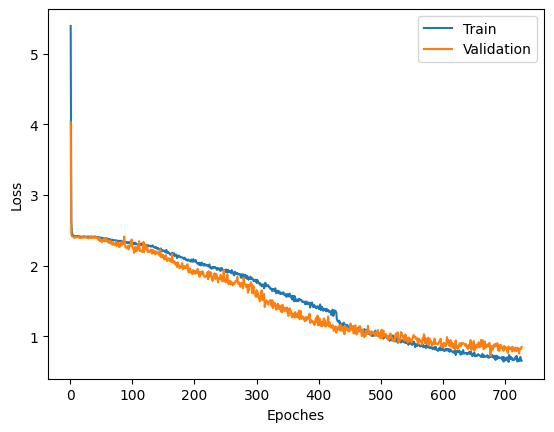

In [13]:
plot_loss(history)


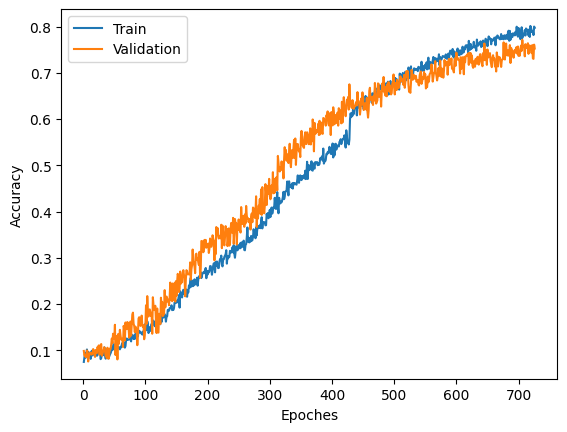

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
